# Model Evaluation for Income Inequality Predictions

This notebook evaluates the performance of our models for predicting income inequality metrics:
- GINI coefficient
- Top 10% wealth share
- Bottom 10% wealth share

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json
import os
import warnings
warnings.filterwarnings("ignore")

# Set the aesthetic style of the plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Load the Prediction Data

We'll load both the regular and best model predictions for each metric.

In [11]:
# Define the metrics
metrics = ['GINI', 'top10pct_wealth_share', 'bottom10pct_wealth_share']

# Create dictionaries to store the dataframes
predictions = {}
best_predictions = {}

# Load the prediction data
for metric in metrics:
    predictions[metric] = pd.read_csv(f'output/predictions/xgb_predictions_{metric}.csv')
    best_predictions[metric] = pd.read_csv(f'output/predictions/xgb_best_predictions_{metric}.csv')
    
    # Display the first few rows
    print(f"Regular predictions for {metric}:")
    display(predictions[metric].head())
    
    print(f"Best model predictions for {metric}:")
    display(best_predictions[metric].head())

Regular predictions for GINI:


Actual  Predicted
0    34.0  33.702740
1    47.4  37.093470
2    33.4  33.174920
3    36.7  37.136364
4    52.3  47.951650

Best model predictions for GINI:


Actual  Predicted
0    34.0  33.256138
1    47.4  39.451378
2    33.4  33.695270
3    36.7  37.220610
4    52.3  51.540794

Regular predictions for top10pct_wealth_share:


Actual  Predicted
0    25.4  25.156800
1    36.9  29.114310
2    25.8  24.634174
3    26.0  25.007338
4    40.2  39.721375

Best model predictions for top10pct_wealth_share:


Actual  Predicted
0    25.4  25.080130
1    36.9  30.396393
2    25.8  25.078585
3    26.0  26.129725
4    40.2  39.697056

Regular predictions for bottom10pct_wealth_share:


Actual  Predicted
0     2.7   2.873019
1     1.8   2.763535
2     2.9   3.008634
3     2.8   3.043082
4     1.5   1.763842

Best model predictions for bottom10pct_wealth_share:


Actual  Predicted
0     2.7   2.719647
1     1.8   2.814764
2     2.9   2.951713
3     2.8   3.006801
4     1.5   1.551752

## Calculate Evaluation Metrics

Let's calculate several evaluation metrics for each model and metric combination.

In [12]:
def evaluate_predictions(actual, predicted):
    """Calculate evaluation metrics for model predictions."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    # Calculate percentage error metrics
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

# Create a dataframe to store evaluation results
results = []

for metric in metrics:
    # Regular model evaluation
    reg_eval = evaluate_predictions(predictions[metric]['Actual'], predictions[metric]['Predicted'])
    reg_eval['Metric'] = metric
    reg_eval['Model'] = 'Regular'
    results.append(reg_eval)
    
    # Best model evaluation
    best_eval = evaluate_predictions(best_predictions[metric]['Actual'], best_predictions[metric]['Predicted'])
    best_eval['Metric'] = metric
    best_eval['Model'] = 'Best'
    results.append(best_eval)

# Convert to dataframe and display
results_df = pd.DataFrame(results)
results_df = results_df[['Metric', 'Model', 'RMSE', 'MAE', 'R²', 'MAPE (%)']]
results_df

Metric    Model      RMSE       MAE        R²   MAPE (%)
0                      GINI  Regular  3.083538  2.112406  0.883888   5.526837
1                      GINI     Best  2.614829  1.555443  0.916504   4.013426
2     top10pct_wealth_share  Regular  2.827377  1.823562  0.847043   5.980095
3     top10pct_wealth_share     Best  2.490099  1.373638  0.881359   4.410629
4  bottom10pct_wealth_share  Regular  0.324350  0.238397  0.899007  14.074680
5  bottom10pct_wealth_share     Best  0.272710  0.181994  0.928605   9.728746

## Visualize Model Performance

Let's create some visualizations to better understand model performance.

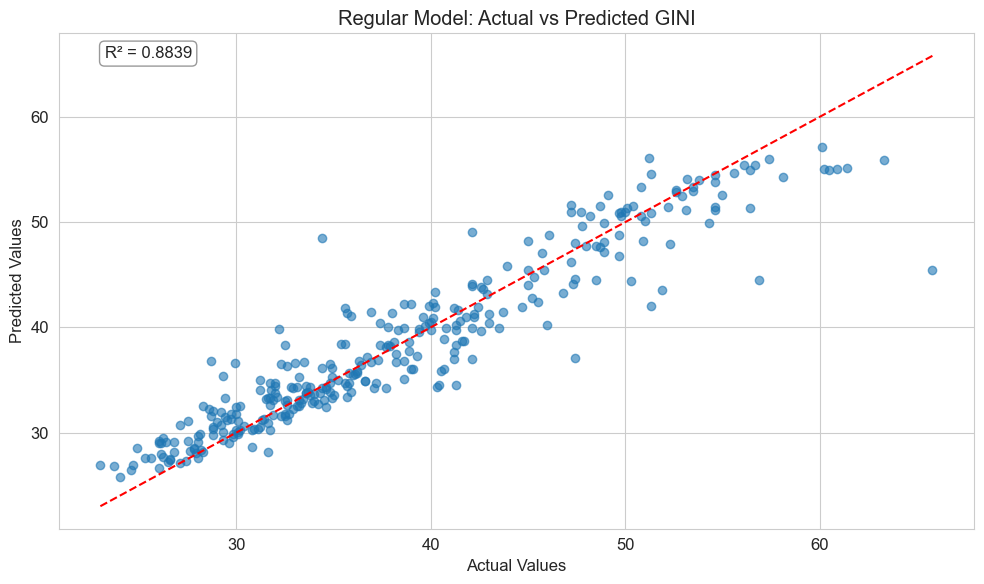

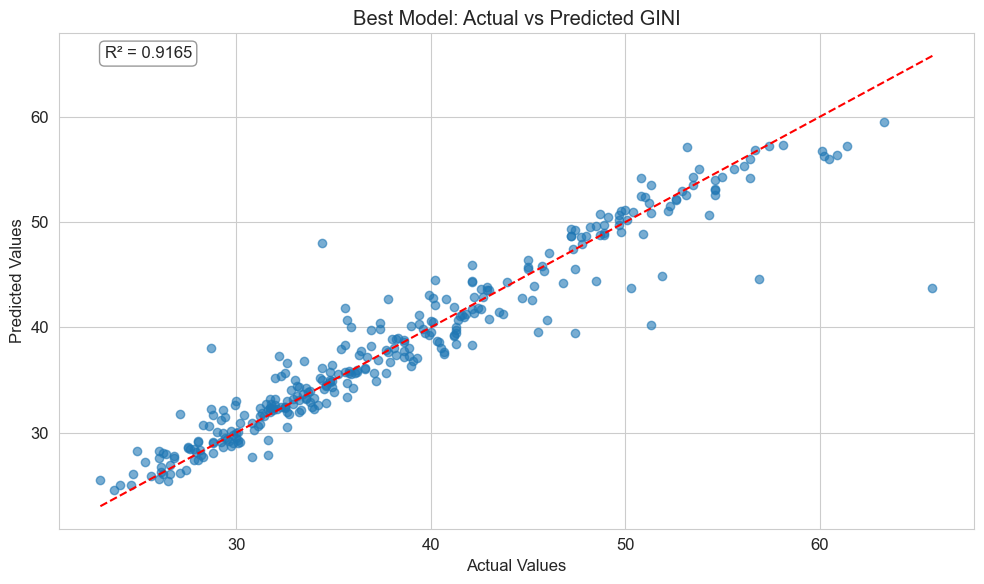

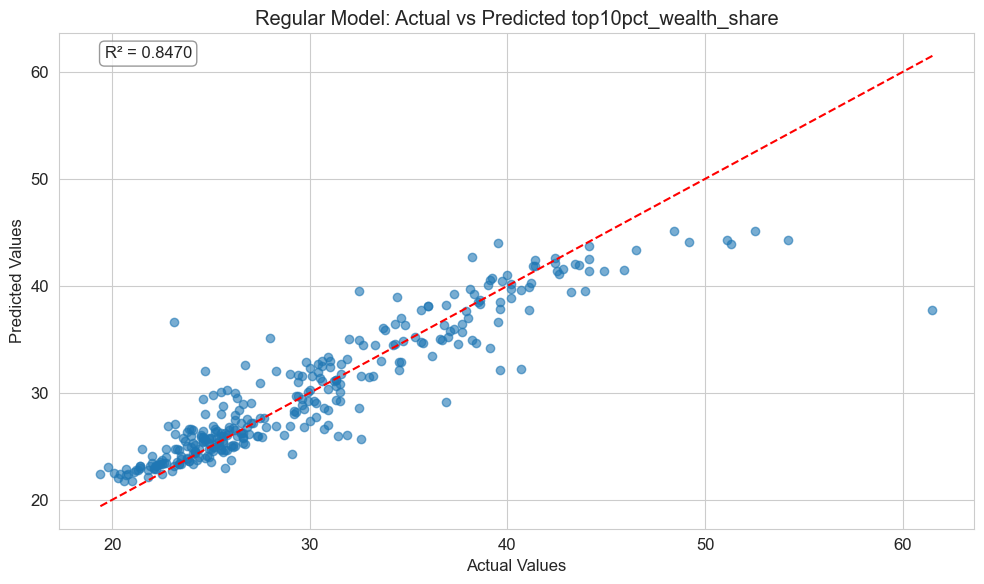

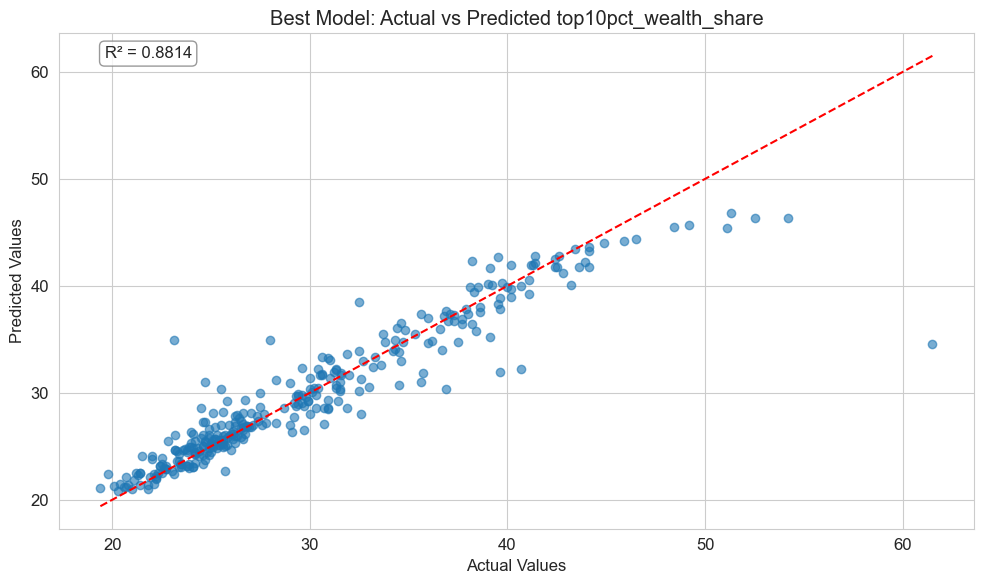

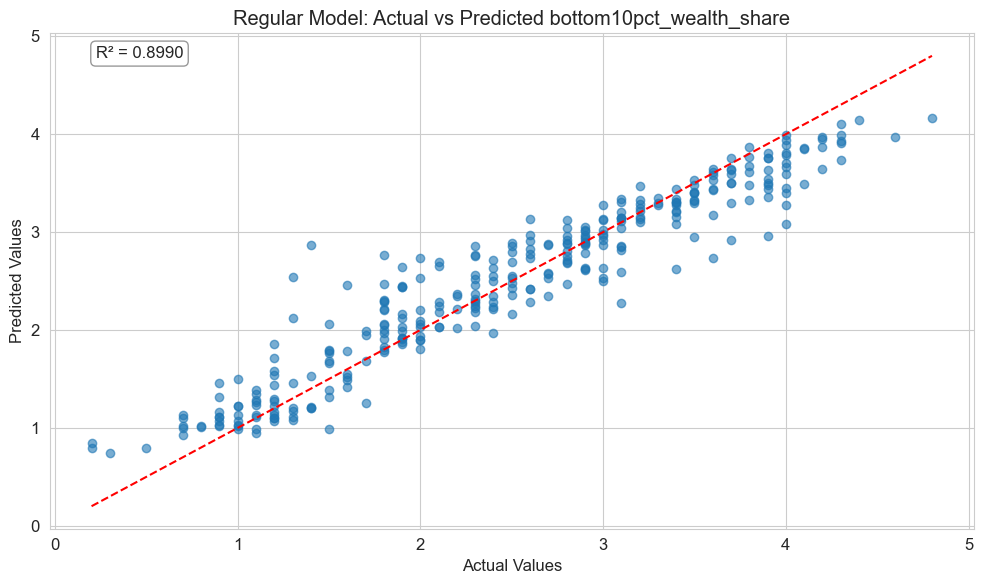

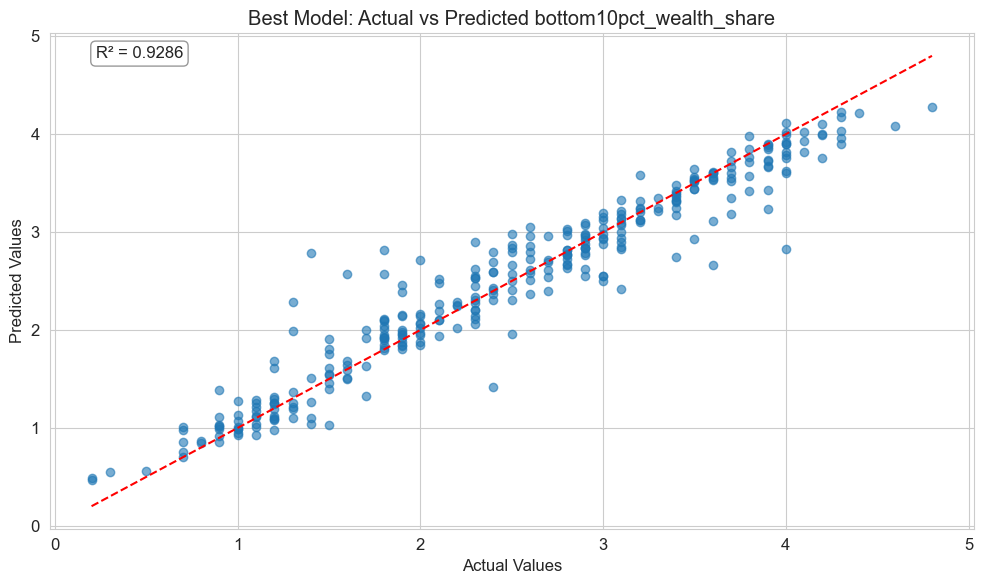

In [13]:
# Function to create scatter plot of actual vs predicted values
def plot_actual_vs_predicted(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.6)
    
    # Add perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    
    # Add R² value to plot
    r2 = r2_score(actual, predicted)
    plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    return plt.gcf()

# Create and display scatter plots for each metric and model
for metric in metrics:
    # Regular model
    plot_actual_vs_predicted(
        predictions[metric]['Actual'], 
        predictions[metric]['Predicted'],
        f'Regular Model: Actual vs Predicted {metric}'
    )
    plt.show()
    
    # Best model
    plot_actual_vs_predicted(
        best_predictions[metric]['Actual'], 
        best_predictions[metric]['Predicted'],
        f'Best Model: Actual vs Predicted {metric}'
    )
    plt.show()

## Residual Analysis

Let's analyze the residuals (prediction errors) to check for patterns or biases.

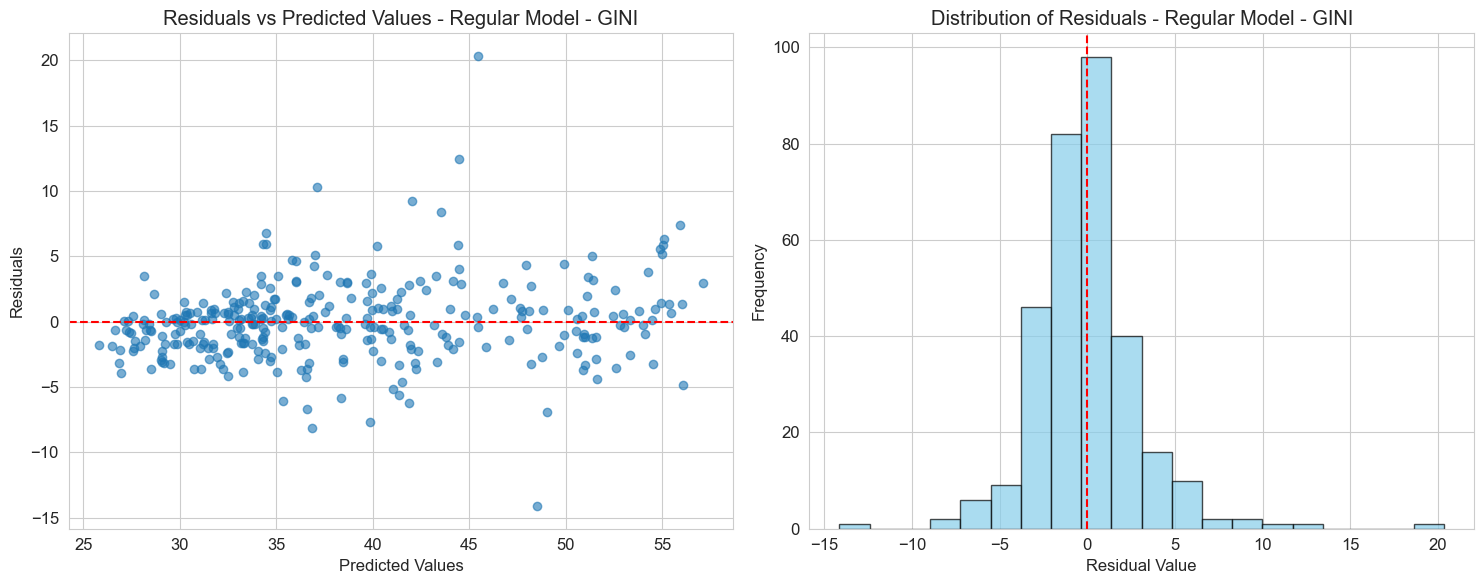

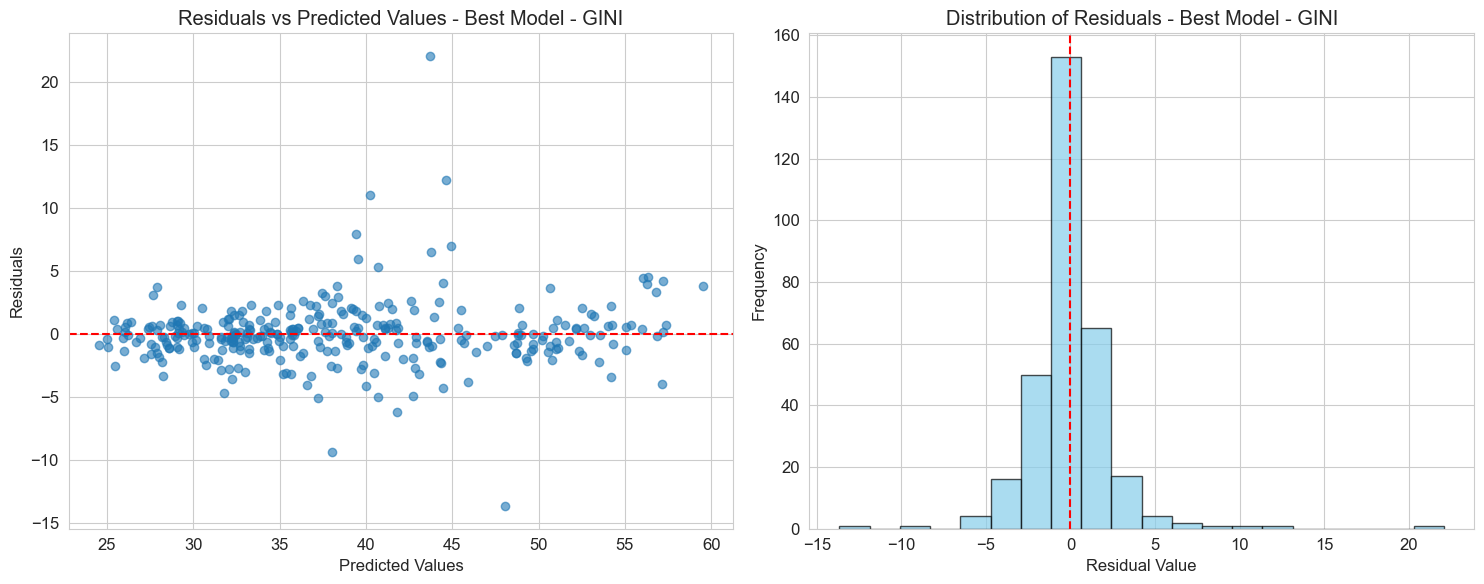

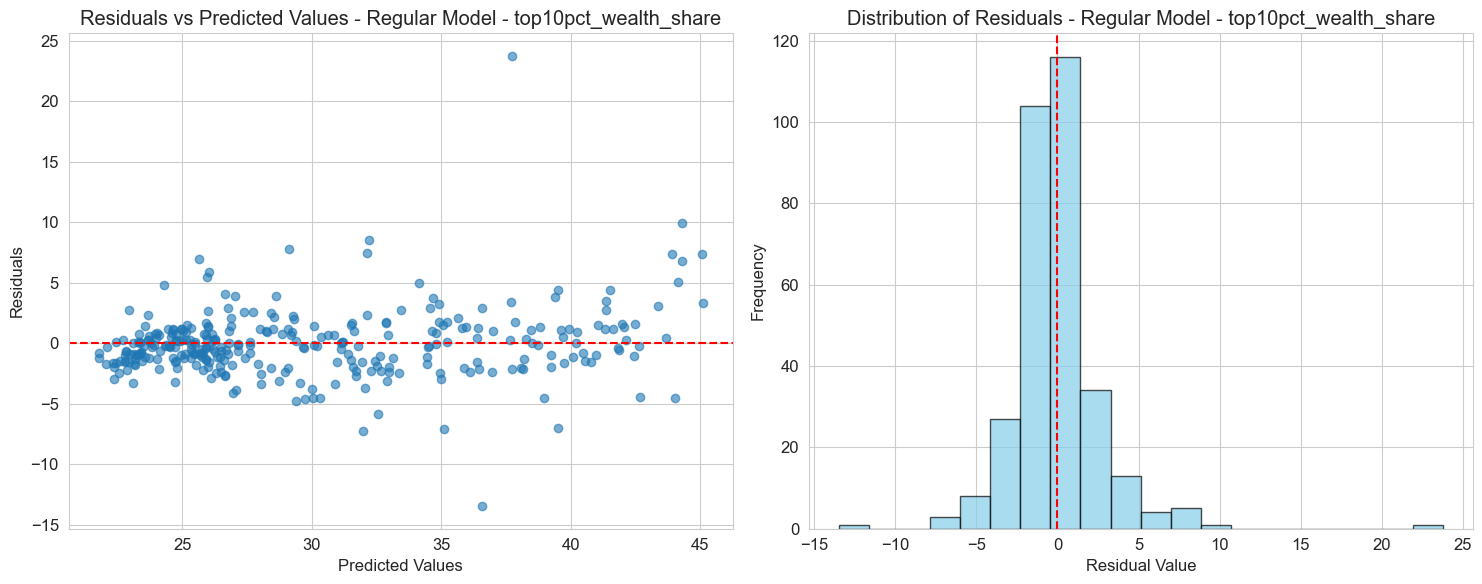

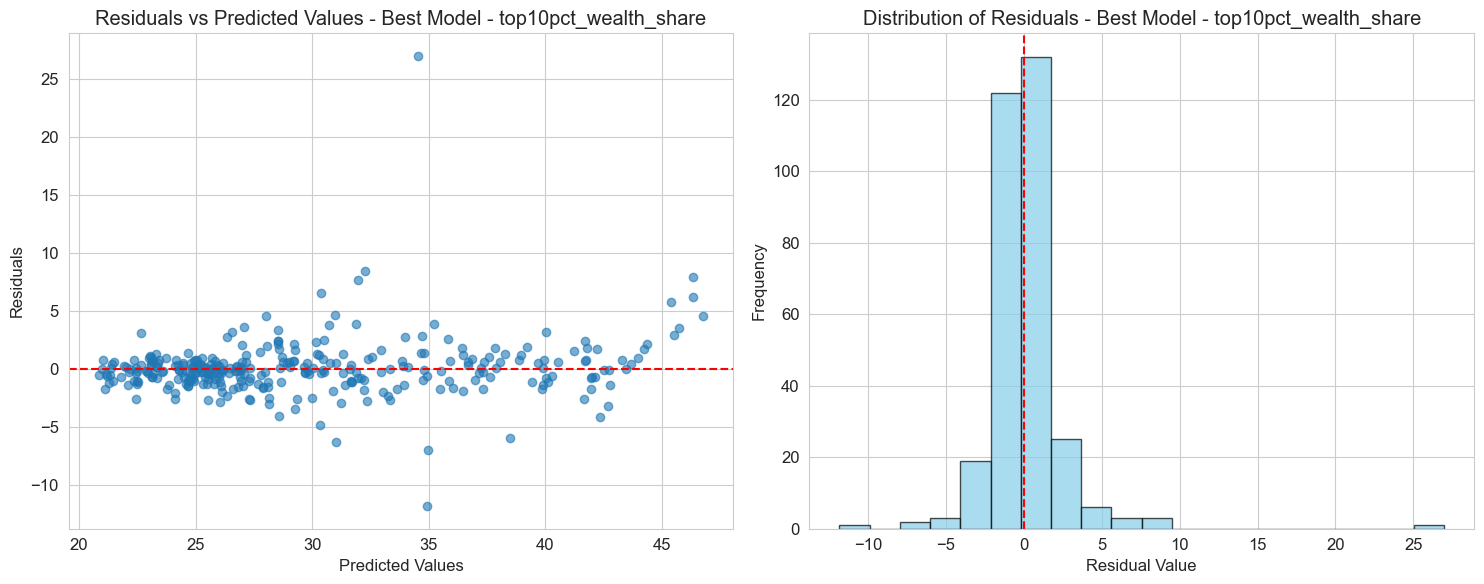

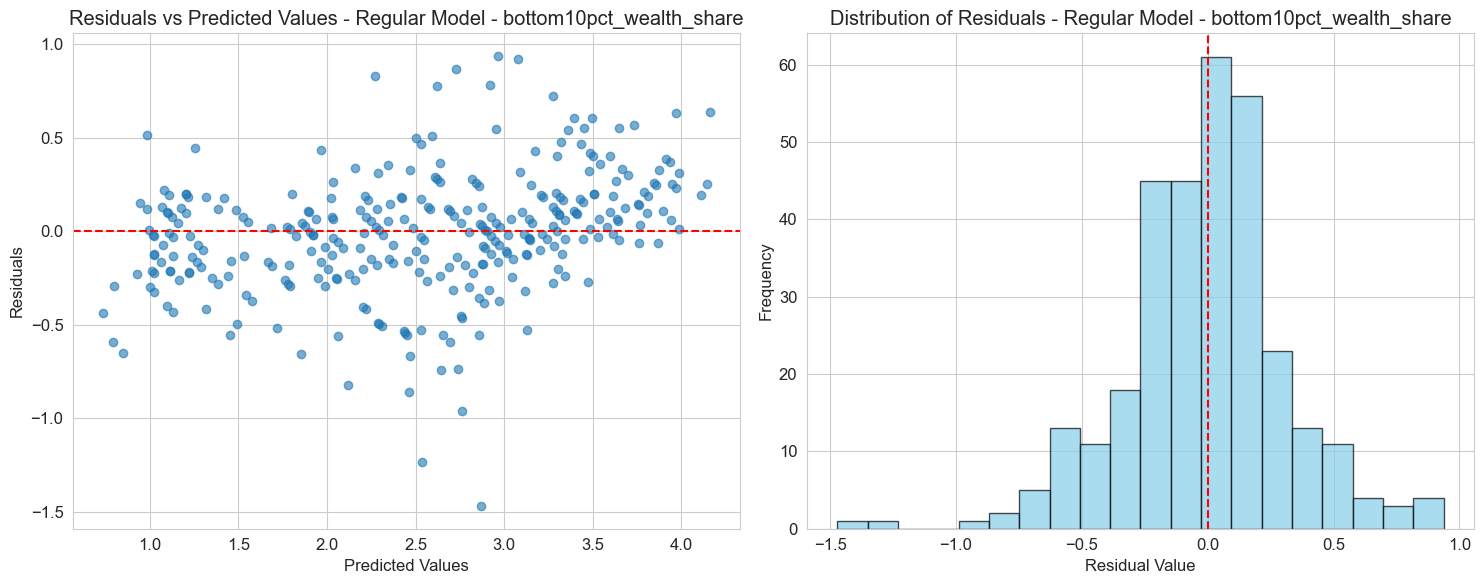

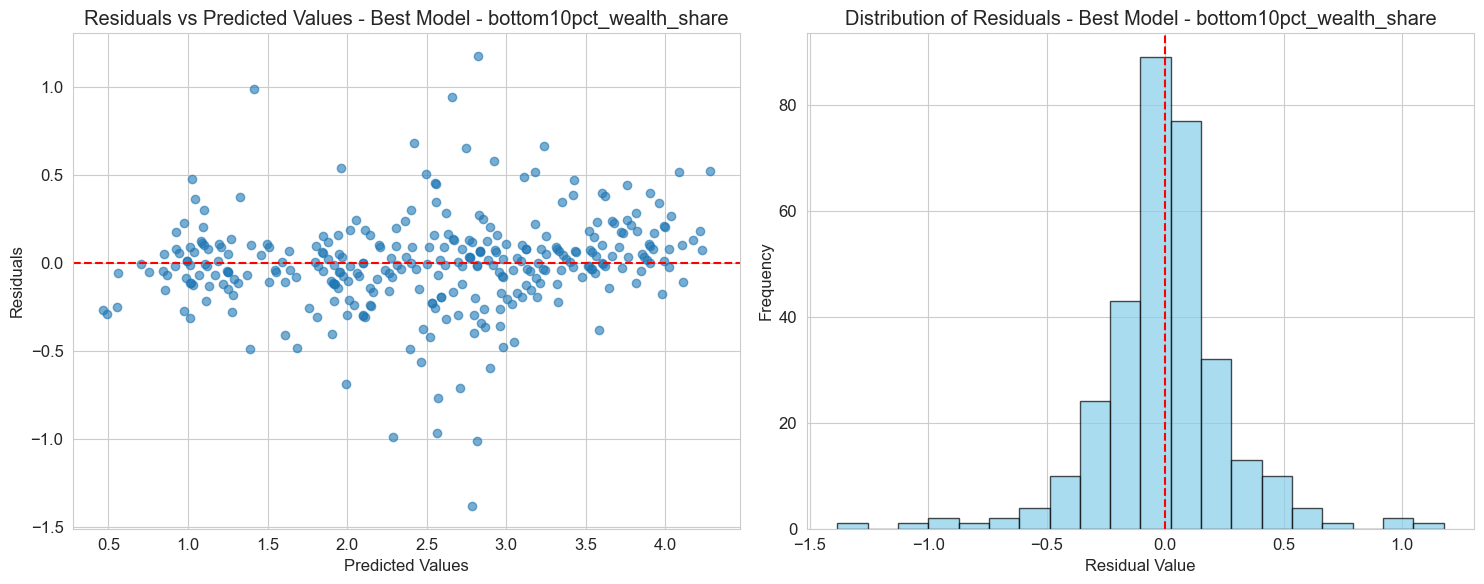

In [14]:
# Function to plot residuals
def plot_residuals(actual, predicted, title):
    residuals = actual - predicted
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residuals vs predicted values
    ax1.scatter(predicted, residuals, alpha=0.6)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title(f'Residuals vs Predicted Values - {title}')
    ax1.grid(True)
    
    # Histogram of residuals
    ax2.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0, color='r', linestyle='--')
    ax2.set_xlabel('Residual Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Distribution of Residuals - {title}')
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

# Create and display residual plots for each metric and model
for metric in metrics:
    # Regular model
    plot_residuals(
        predictions[metric]['Actual'], 
        predictions[metric]['Predicted'],
        f'Regular Model - {metric}'
    )
    plt.show()
    
    # Best model
    plot_residuals(
        best_predictions[metric]['Actual'], 
        best_predictions[metric]['Predicted'],
        f'Best Model - {metric}'
    )
    plt.show()

## Model Parameters Comparison

Let's examine the hyperparameters of the best models.

In [15]:
# Load hyperparameters for best models
hyperparams = {}

for metric in metrics:
    # Handle the different file naming convention
    if metric == 'top10pct_wealth_share':
        file_metric = 'top10pct_wealth_share'
    elif metric == 'bottom10pct_wealth_share':
        file_metric = 'bottom10pct_wealth_share'
    else:
        file_metric = metric
        
    hyperparam_path = f'output/models/best_model_params_{file_metric}.json'
    
    try:
        with open(hyperparam_path, 'r') as f:
            hyperparams[metric] = json.load(f)
        print(f"Loaded hyperparameters for {metric}")
    except Exception as e:
        print(f"Error loading hyperparameters for {metric}: {e}")
        hyperparams[metric] = {}

# Display hyperparameters in a nice format
for metric, params in hyperparams.items():
    print(f"\n=== Hyperparameters for {metric} ===\n")
    for param, value in params.items():
        print(f"{param}: {value}")

Loaded hyperparameters for GINI
Loaded hyperparameters for top10pct_wealth_share
Loaded hyperparameters for bottom10pct_wealth_share

=== Hyperparameters for GINI ===

model__colsample_bylevel: 0.9010517491308082
model__colsample_bytree: 0.9395992960433877
model__gamma: 0.6331108417581415
model__learning_rate: 0.08723901599377133
model__max_depth: 5
model__min_child_weight: 5
model__n_estimators: 133
model__reg_alpha: 1.8688165721823782
model__reg_lambda: 1.464786088638586
model__subsample: 0.9228761938728909

=== Hyperparameters for top10pct_wealth_share ===

model__colsample_bylevel: 0.7407960993273509
model__colsample_bytree: 0.9508410181190827
model__gamma: 1.3047560001770928
model__learning_rate: 0.05116466295321231
model__max_depth: 5
model__min_child_weight: 2
model__n_estimators: 170
model__reg_alpha: 0.7575176304276007
model__reg_lambda: 3.4392701633892786
model__subsample: 0.9233807090140386

=== Hyperparameters for bottom10pct_wealth_share ===

model__colsample_bylevel: 0.97

## Feature Importance Analysis

Let's examine the most important features for each model.

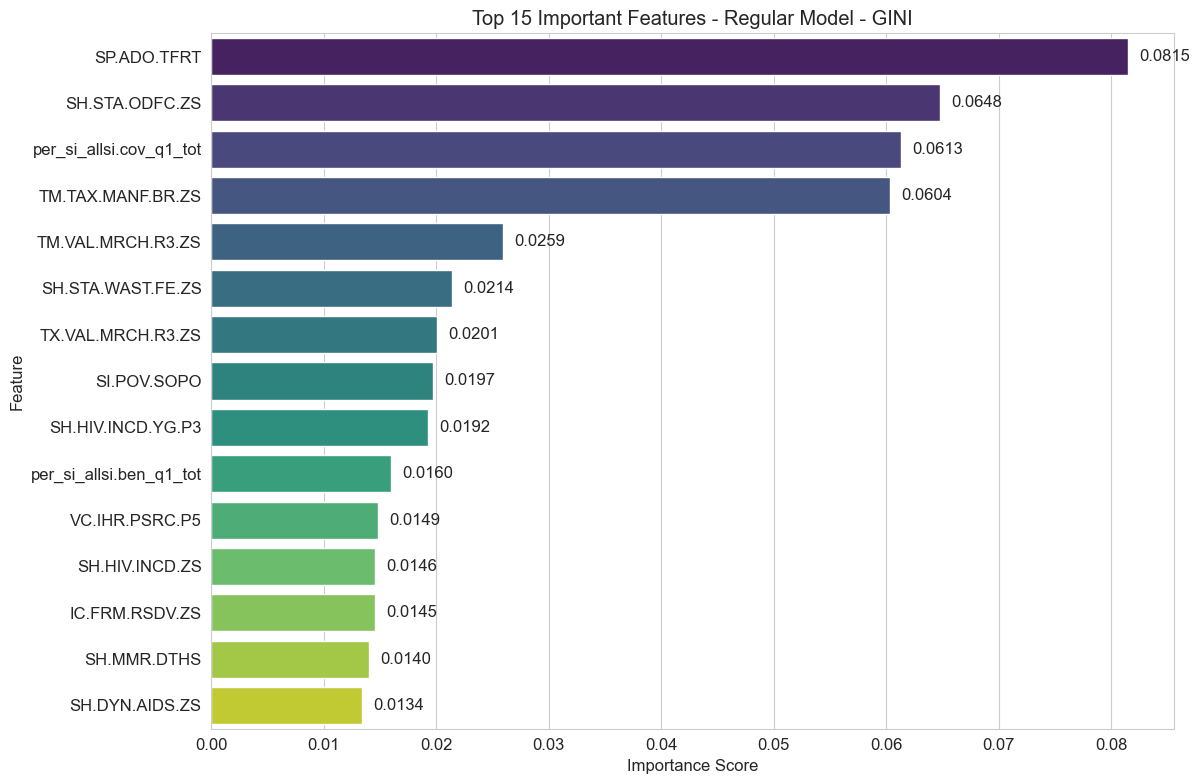

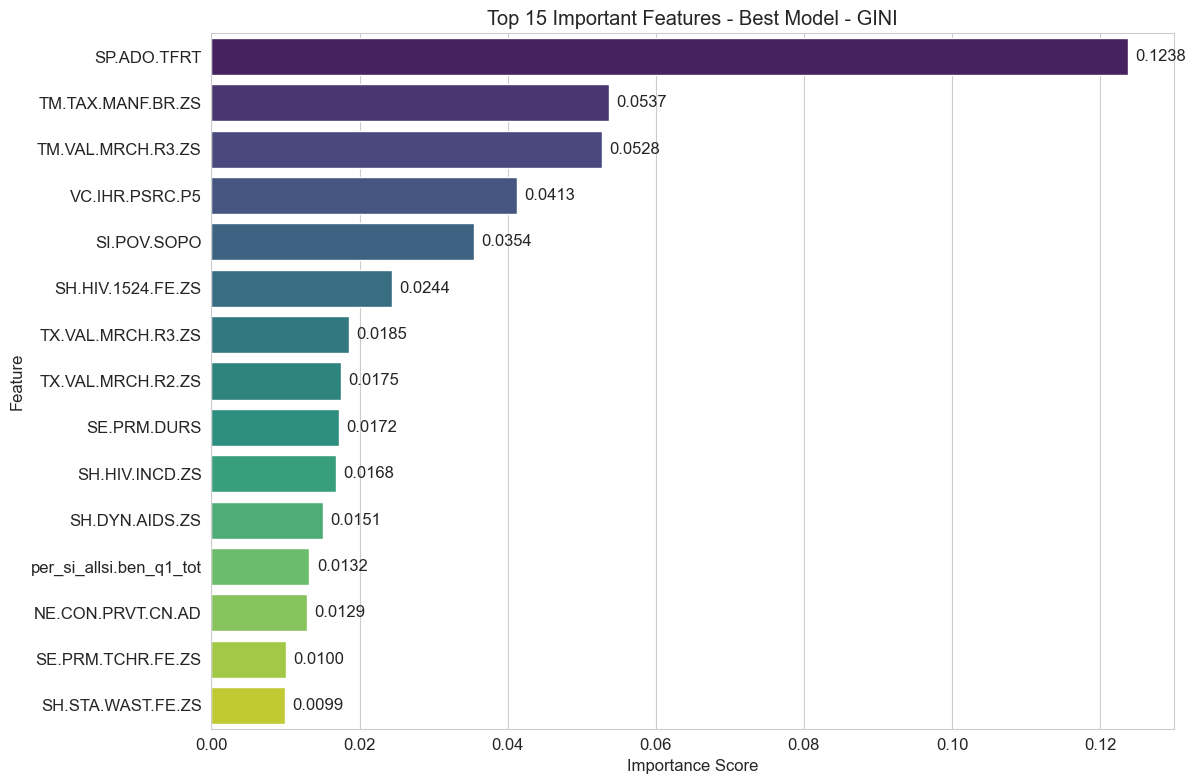

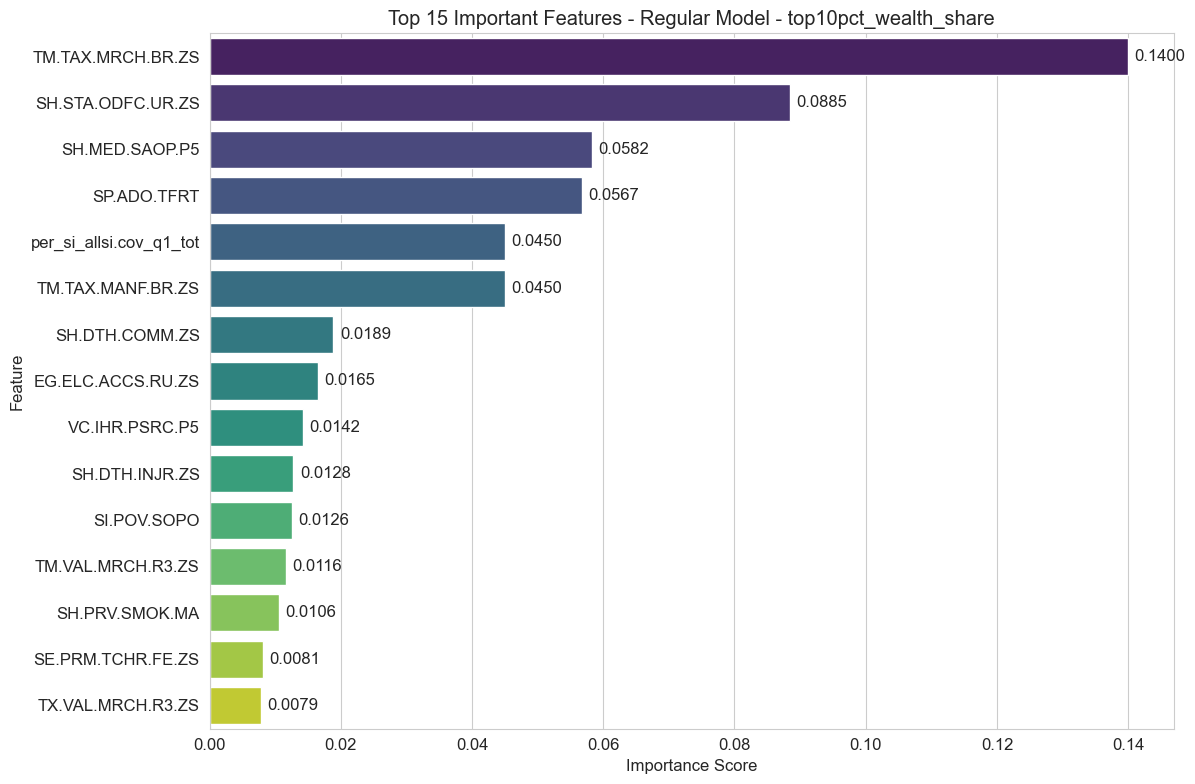

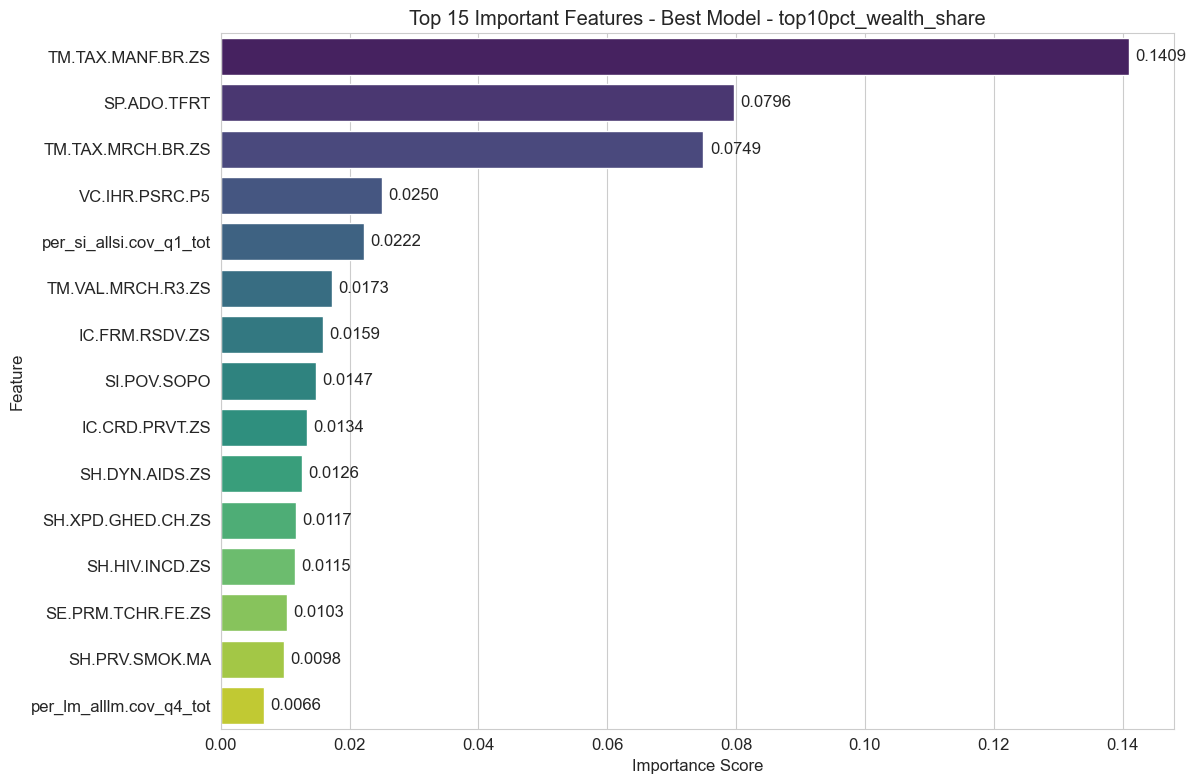

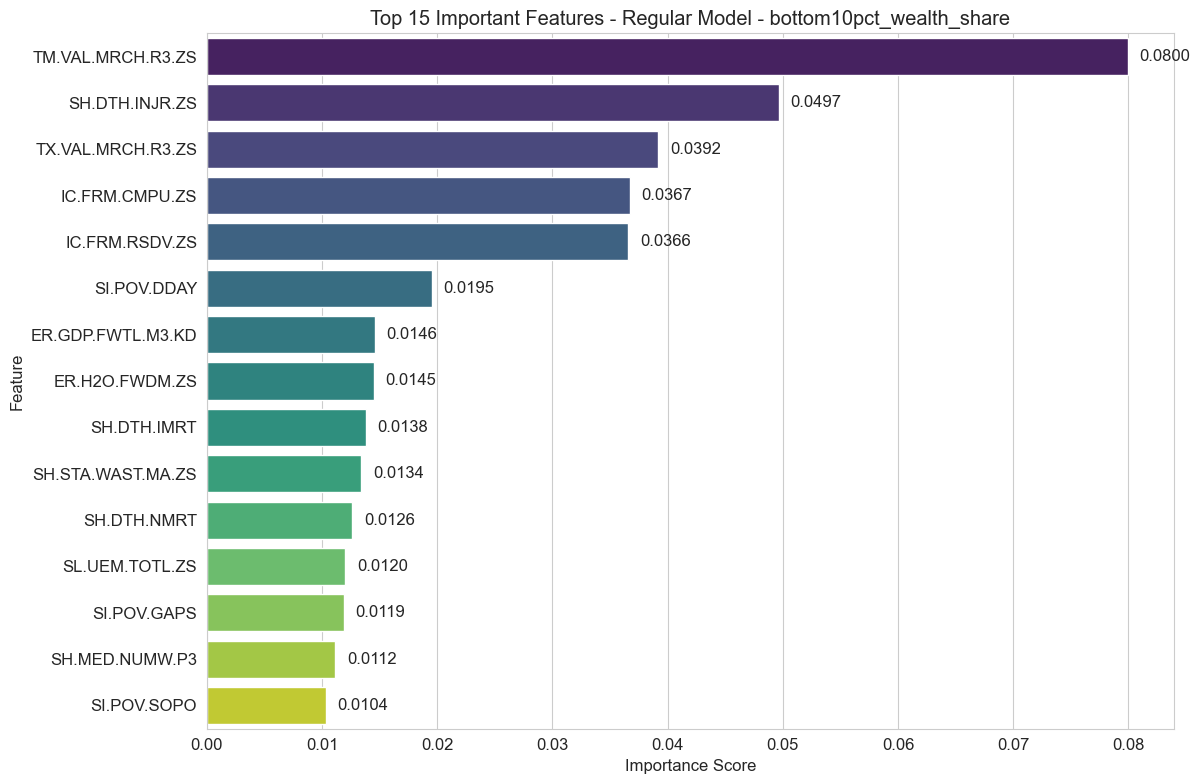

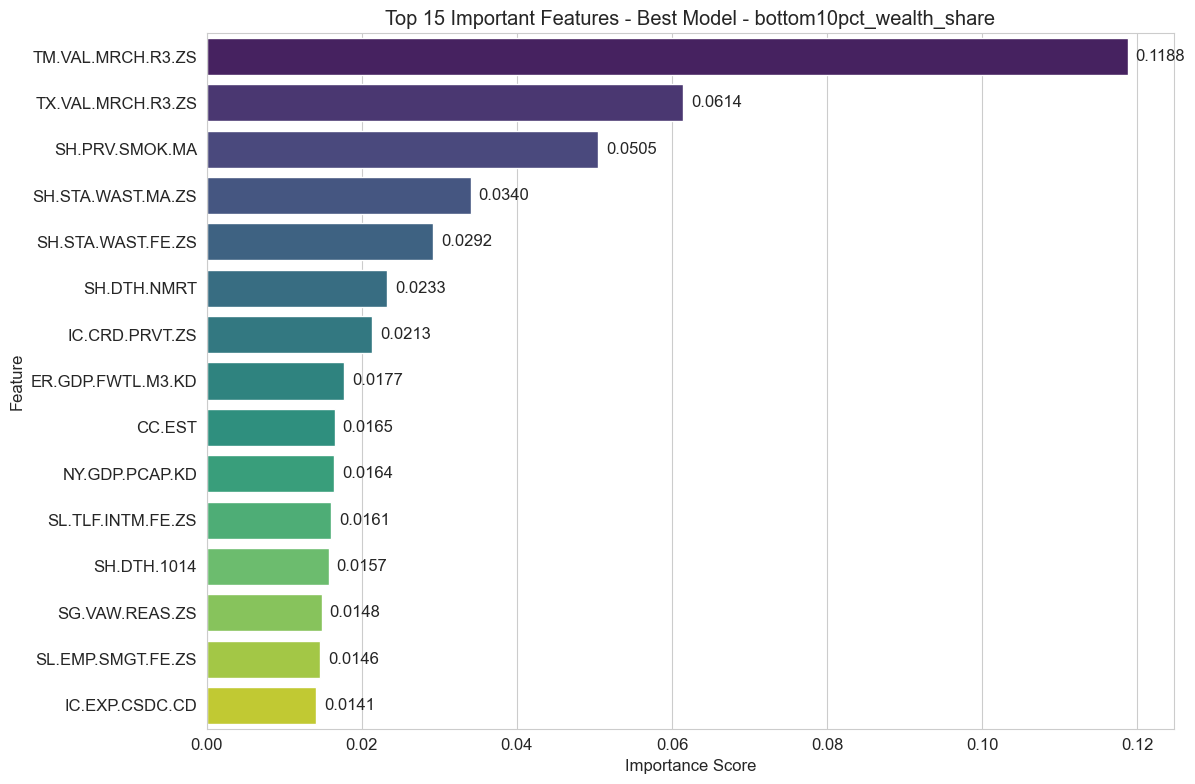

In [16]:
# Load feature importance data
feature_importances = {}
best_feature_importances = {}

for metric in metrics:
    # Handle the different file naming convention
    if metric == 'top10pct_wealth_share':
        file_metric = 'top10pct_wealth_share'
    elif metric == 'bottom10pct_wealth_share':
        file_metric = 'bottom10pct_wealth_share'
    else:
        file_metric = metric
    
    # Load regular feature importances
    try:
        feature_importances[metric] = pd.read_csv(f'output/feature_importance/feature_importances_{file_metric}.csv')
    except Exception as e:
        print(f"Error loading feature importances for {metric}: {e}")
        feature_importances[metric] = pd.DataFrame(columns=['Feature', 'Importance'])
    
    # Load best model feature importances
    try:
        best_feature_importances[metric] = pd.read_csv(f'output/feature_importance/feature_importances_best_{file_metric}.csv')
    except Exception as e:
        print(f"Error loading best feature importances for {metric}: {e}")
        best_feature_importances[metric] = pd.DataFrame(columns=['Feature', 'Importance'])

# Function to plot top N features
def plot_top_features(importance_df, title, top_n=15):
    if importance_df.empty:
        plt.figure(figsize=(10, 2))
        plt.text(0.5, 0.5, "No feature importance data available", 
                 horizontalalignment='center', verticalalignment='center')
        plt.axis('off')
        return plt.gcf()
    
    # Get top N features
    top_features = importance_df.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))

    ax = sns.barplot(x=top_features['Importance'], y=top_features['Feature'], palette='viridis', hue=top_features['Feature'], legend=False)
    
    plt.title(title)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    
    # Add values to the bars
    for i, v in enumerate(top_features['Importance']):
        ax.text(v + 0.001, i, f"{v:.4f}", va='center')
    
    return plt.gcf()

# Plot top features for each metric and model
for metric in metrics:
    # Regular model
    plot_top_features(
        feature_importances[metric],
        f'Top 15 Important Features - Regular Model - {metric}'
    )
    plt.show()
    
    # Best model
    plot_top_features(
        best_feature_importances[metric],
        f'Top 15 Important Features - Best Model - {metric}'
    )
    plt.show()

## Error Distribution Analysis

Let's analyze how errors are distributed across the prediction range.

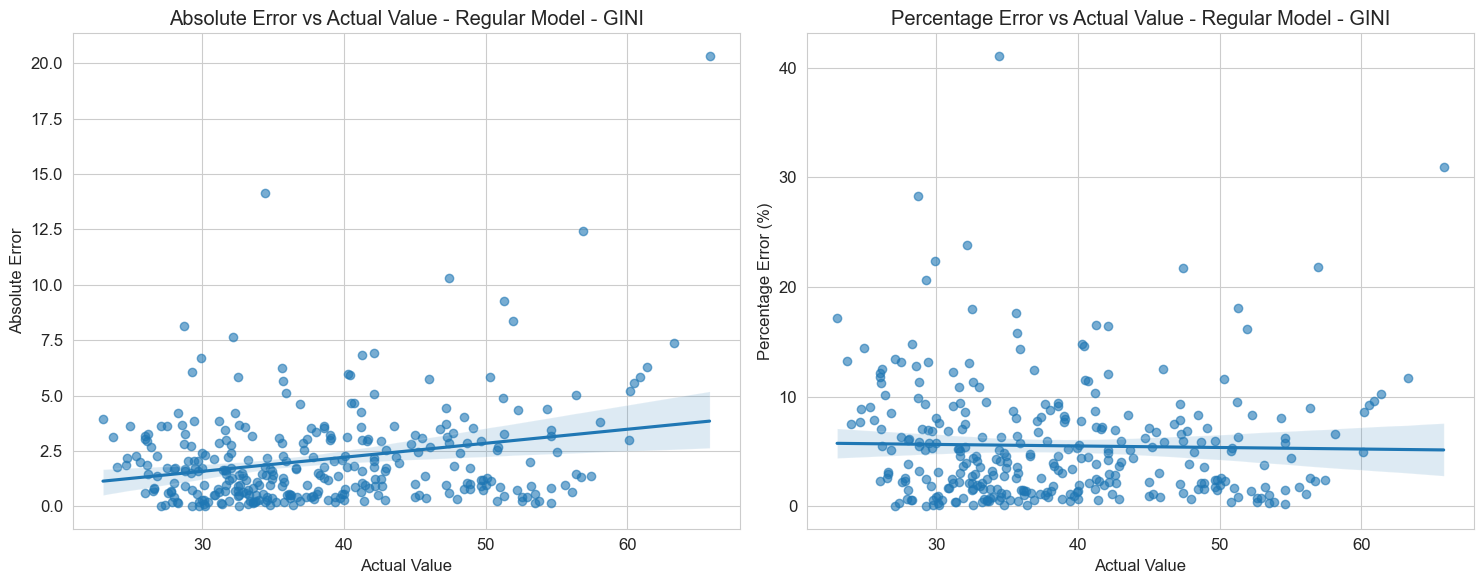

=== Error Summary for Regular Model - GINI ===

Absolute Error Statistics:
count    317.000000
mean       2.112406
std        2.249870
min        0.003556
25%        0.618056
50%        1.498225
75%        2.988072
max       20.337270
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       5.526837
std        5.390713
min        0.012137
25%        1.593550
50%        4.118557
75%        7.745515
max       41.068372
Name: Percentage Error, dtype: float64

--------------------------------------------------



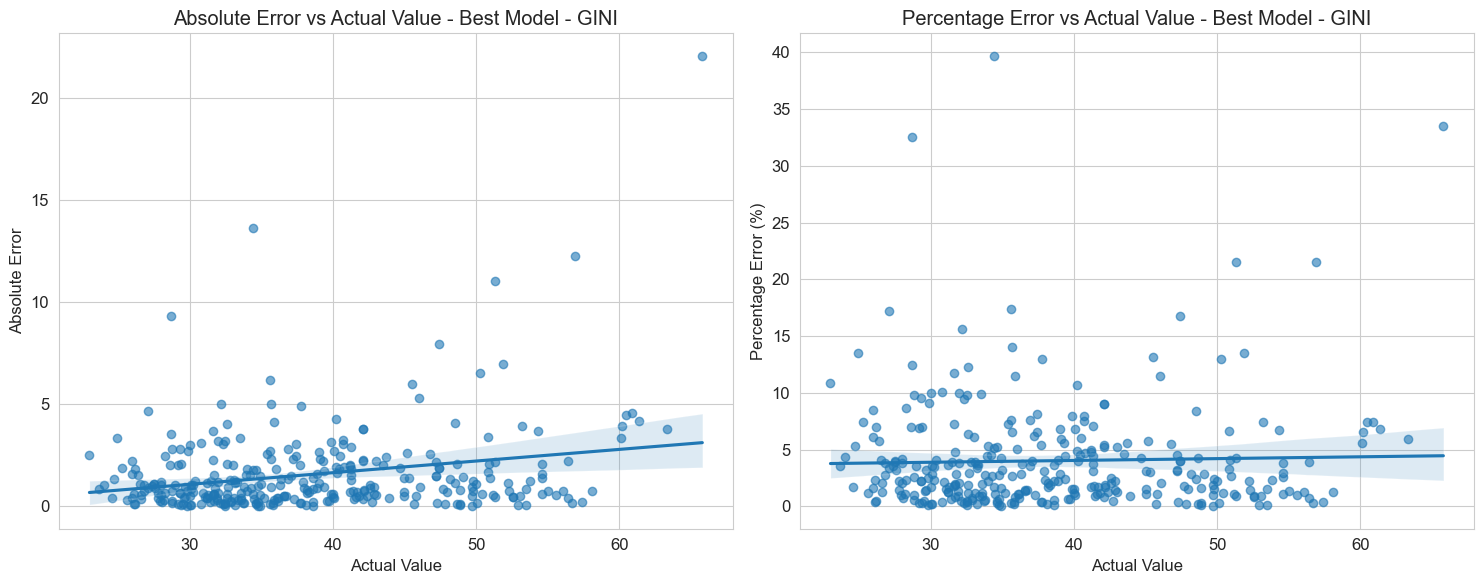

=== Error Summary for Best Model - GINI ===

Absolute Error Statistics:
count    317.000000
mean       1.555443
std        2.105210
min        0.002415
25%        0.418360
50%        0.945052
75%        2.009907
max       22.074902
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       4.013426
std        4.798989
min        0.004859
25%        1.145085
50%        2.579267
75%        5.192116
max       39.700535
Name: Percentage Error, dtype: float64

--------------------------------------------------



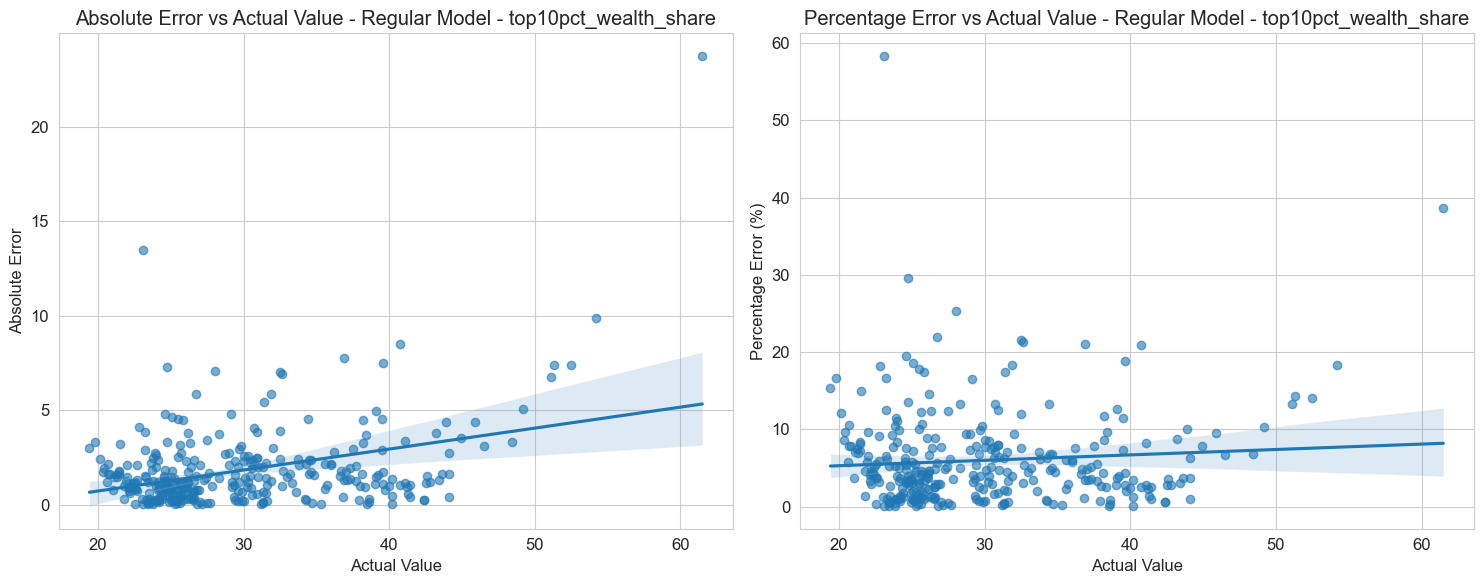

=== Error Summary for Regular Model - top10pct_wealth_share ===

Absolute Error Statistics:
count    317.000000
mean       1.823562
std        2.164130
min        0.011914
25%        0.660780
50%        1.257077
75%        2.278642
max       23.771217
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       5.980095
std        6.107905
min        0.044455
25%        2.283350
50%        4.502309
75%        7.727919
max       58.361195
Name: Percentage Error, dtype: float64

--------------------------------------------------



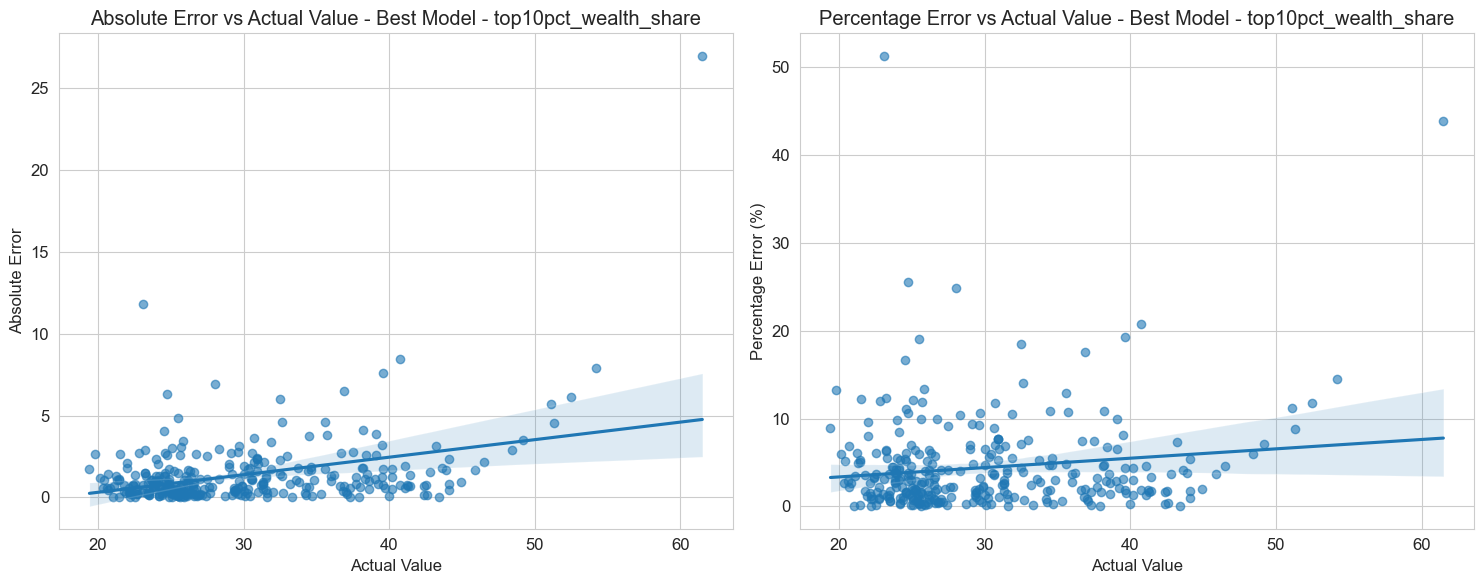

=== Error Summary for Best Model - top10pct_wealth_share ===

Absolute Error Statistics:
count    317.000000
mean       1.373638
std        2.080232
min        0.006224
25%        0.367841
50%        0.801880
75%        1.674603
max       26.959950
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       4.410629
std        5.392741
min        0.028036
25%        1.336090
50%        2.935431
75%        5.528721
max       51.255472
Name: Percentage Error, dtype: float64

--------------------------------------------------



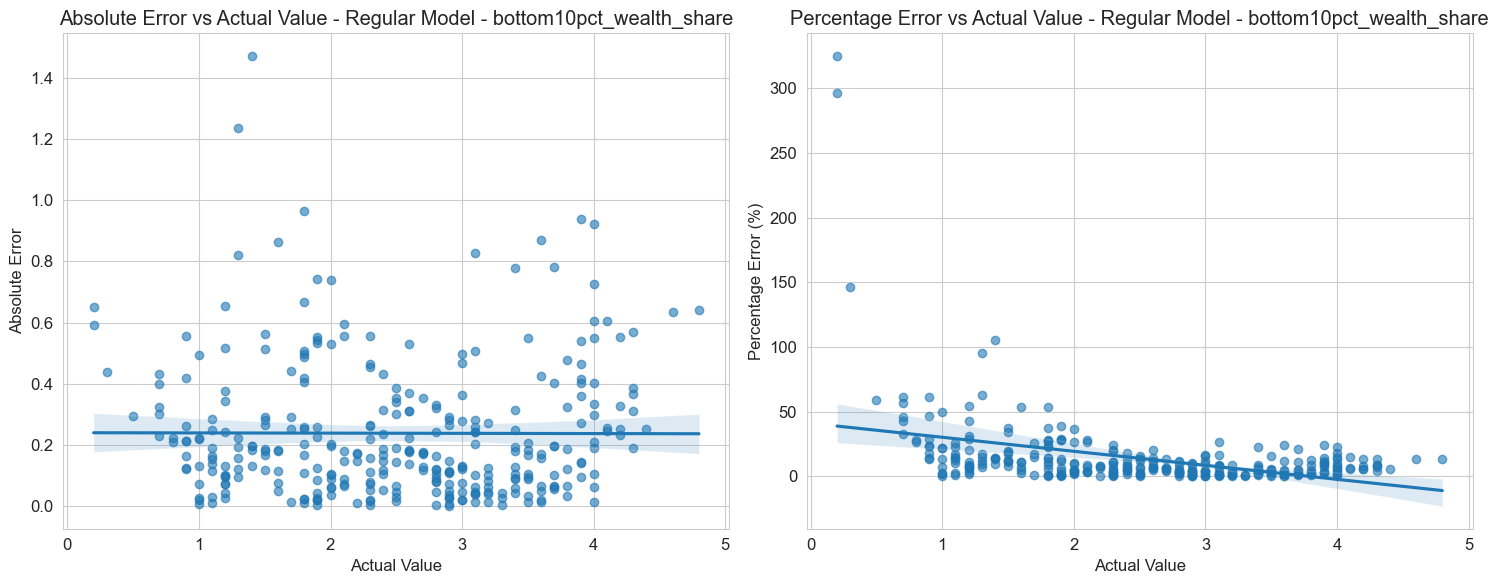

=== Error Summary for Regular Model - bottom10pct_wealth_share ===

Absolute Error Statistics:
count    317.000000
mean       0.238397
std        0.220278
min        0.000051
25%        0.081560
50%        0.179712
75%        0.319914
max        1.471144
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean      14.074680
std       28.515836
min        0.001759
25%        3.116506
50%        7.477700
75%       14.202832
max      325.012200
Name: Percentage Error, dtype: float64

--------------------------------------------------



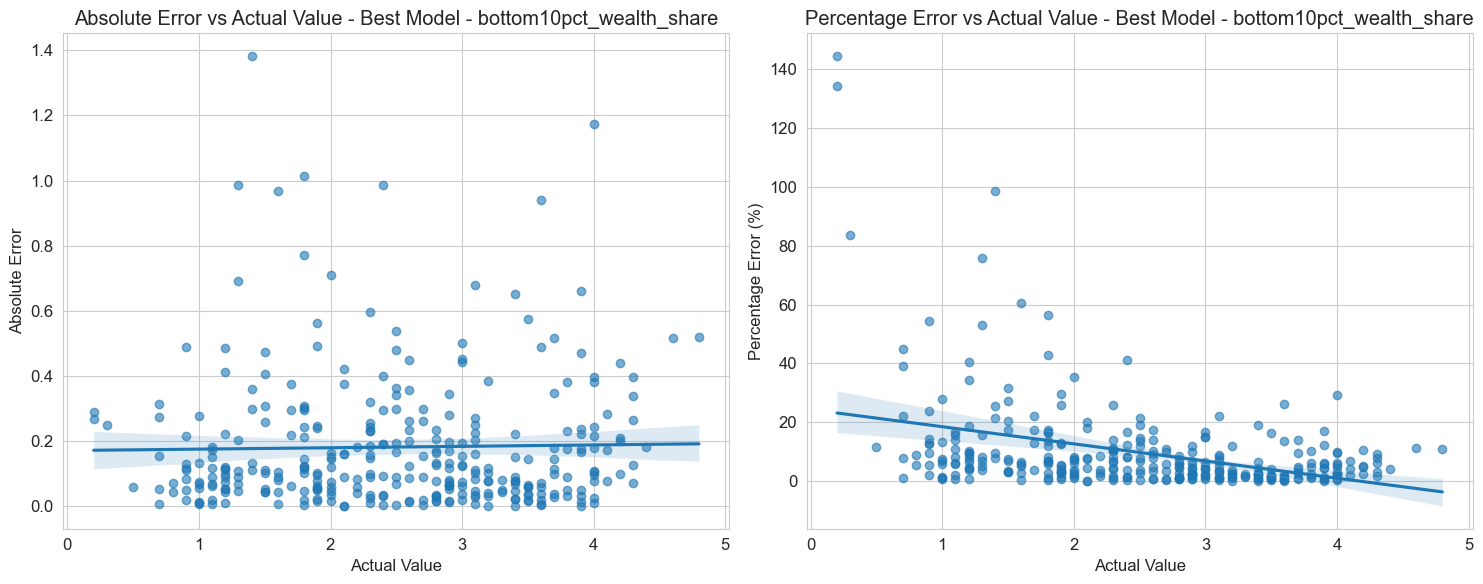

=== Error Summary for Best Model - bottom10pct_wealth_share ===

Absolute Error Statistics:
count    317.000000
mean       0.181994
std        0.203419
min        0.000402
25%        0.051713
50%        0.112752
75%        0.240722
max        1.382847
Name: Absolute Error, dtype: float64

Percentage Error Statistics:
count    317.000000
mean       9.728746
std       16.071041
min        0.012572
25%        2.112033
50%        5.409628
75%       10.527252
max      144.605125
Name: Percentage Error, dtype: float64

--------------------------------------------------



In [17]:
# Function to create error analysis plots
def analyze_error_distribution(actual, predicted, title):
    # Calculate absolute and percentage errors
    abs_error = np.abs(actual - predicted)
    pct_error = (abs_error / actual) * 100
    
    # Create dataframe for analysis
    error_df = pd.DataFrame({
        'Actual': actual,
        'Predicted': predicted,
        'Absolute Error': abs_error,
        'Percentage Error': pct_error
    })
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Absolute error vs actual value
    # Use scatter directly to avoid grouping warning
    ax1.scatter(error_df['Actual'], error_df['Absolute Error'], alpha=0.6)
    # Add a regression line manually
    sns.regplot(x='Actual', y='Absolute Error', data=error_df, ax=ax1, scatter=False)
    ax1.set_xlabel('Actual Value')
    ax1.set_ylabel('Absolute Error')
    ax1.set_title(f'Absolute Error vs Actual Value - {title}')
    ax1.grid(True)
    
    # Percentage error vs actual value
    # Use scatter directly to avoid grouping warning
    ax2.scatter(error_df['Actual'], error_df['Percentage Error'], alpha=0.6)
    # Add a regression line manually
    sns.regplot(x='Actual', y='Percentage Error', data=error_df, ax=ax2, scatter=False)
    ax2.set_xlabel('Actual Value')
    ax2.set_ylabel('Percentage Error (%)')
    ax2.set_title(f'Percentage Error vs Actual Value - {title}')
    ax2.grid(True)
    
    plt.tight_layout()
    return fig, error_df

# Analyze error distribution for each metric and model
for metric in metrics:
    # Regular model
    fig, error_df = analyze_error_distribution(
        predictions[metric]['Actual'], 
        predictions[metric]['Predicted'],
        f'Regular Model - {metric}'
    )
    plt.show()
    
    # Print summary statistics
    print(f"=== Error Summary for Regular Model - {metric} ===\n")
    print("Absolute Error Statistics:")
    print(error_df['Absolute Error'].describe())
    print("\nPercentage Error Statistics:")
    print(error_df['Percentage Error'].describe())
    print("\n" + "-"*50 + "\n")
    
    # Best model
    fig, error_df = analyze_error_distribution(
        best_predictions[metric]['Actual'], 
        best_predictions[metric]['Predicted'],
        f'Best Model - {metric}'
    )
    plt.show()
    
    # Print summary statistics
    print(f"=== Error Summary for Best Model - {metric} ===\n")
    print("Absolute Error Statistics:")
    print(error_df['Absolute Error'].describe())
    print("\nPercentage Error Statistics:")
    print(error_df['Percentage Error'].describe())
    print("\n" + "-"*50 + "\n")

## Model Comparison

Let's directly compare the regular and best models for each metric.

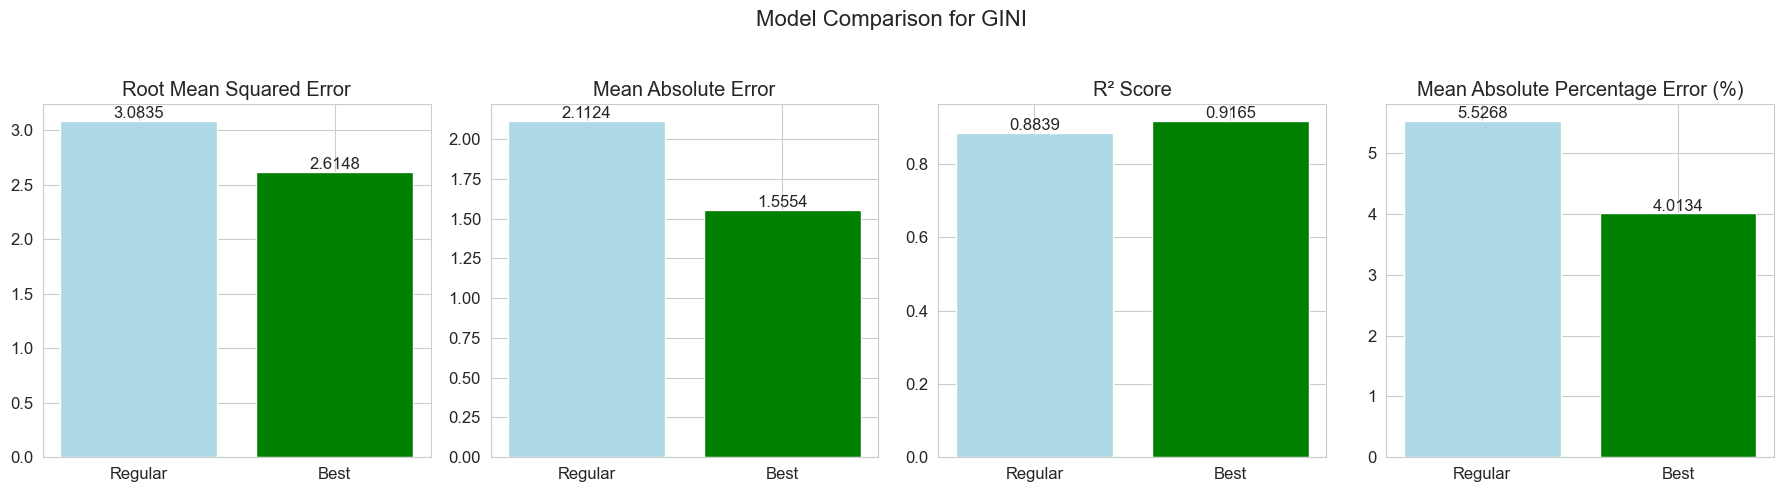

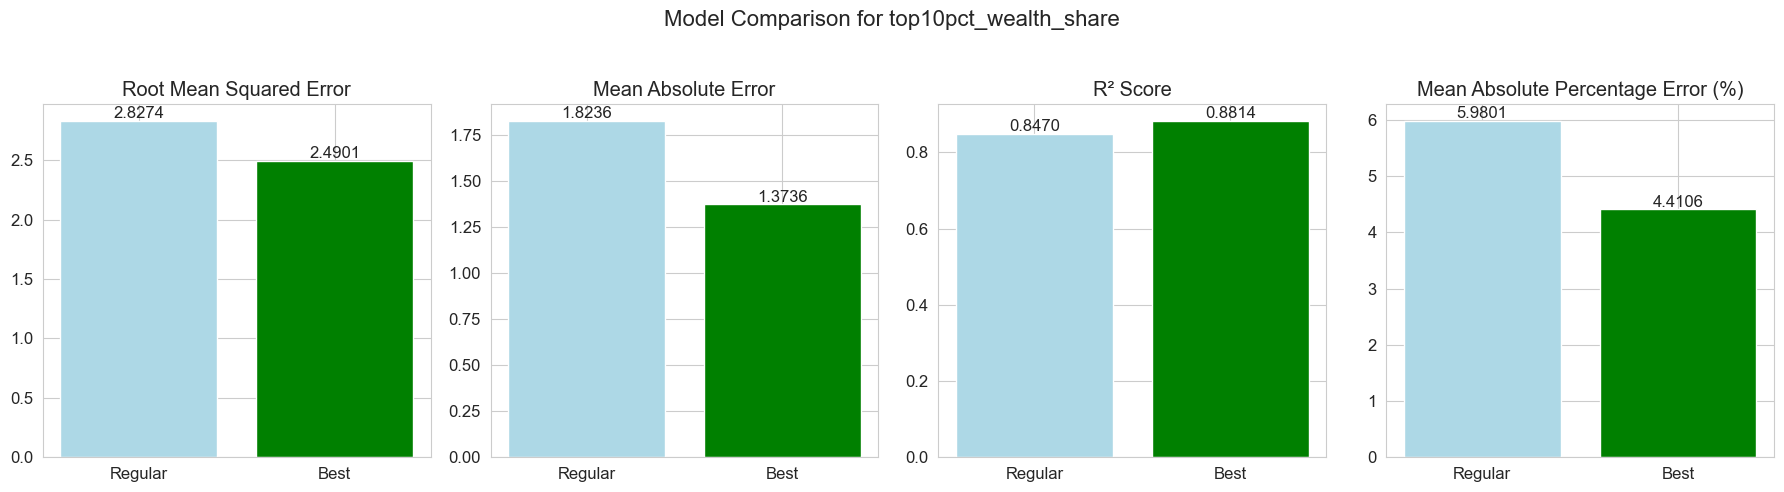

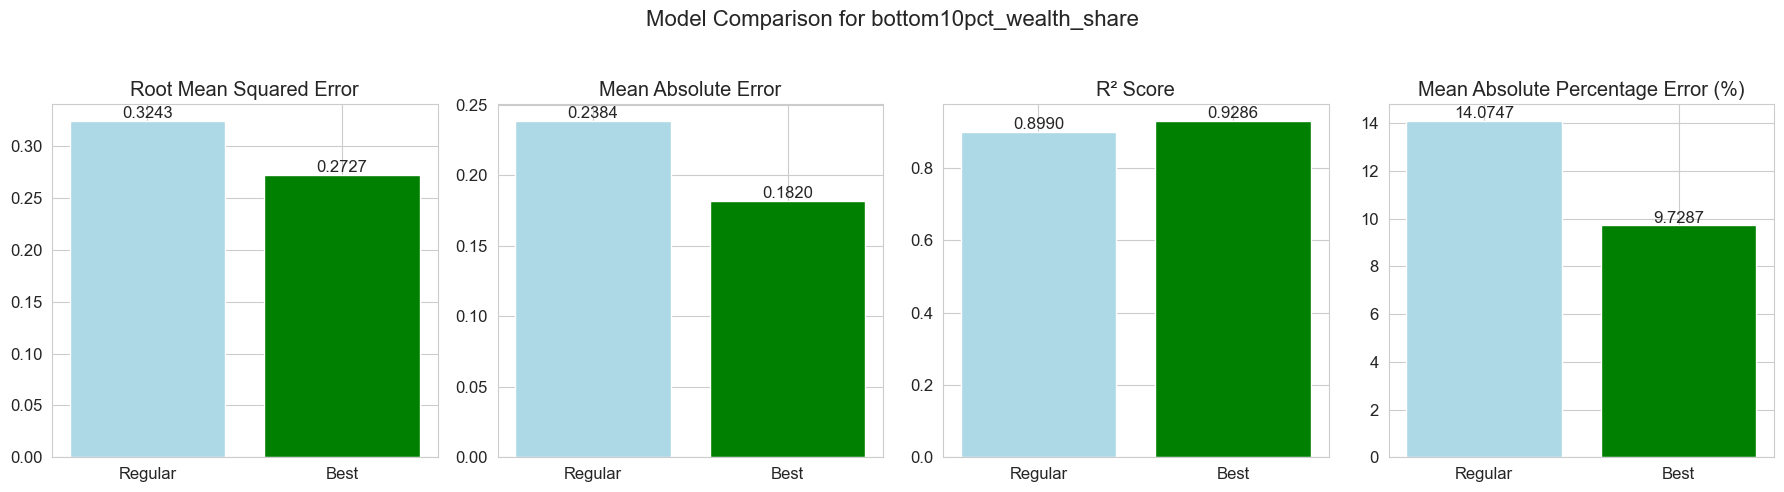

In [18]:
# Create bar charts comparing model performance metrics
def plot_model_comparison(results_df, metric_name):
    # Filter results for the specific metric
    metric_results = results_df[results_df['Metric'] == metric_name].copy()
    
    # Create subplots for each evaluation metric
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    eval_metrics = ['RMSE', 'MAE', 'R²', 'MAPE (%)']
    titles = ['Root Mean Squared Error', 'Mean Absolute Error', 'R² Score', 'Mean Absolute Percentage Error (%)']
    
    for i, (eval_metric, title) in enumerate(zip(eval_metrics, titles)):
        # For R², higher is better
        if eval_metric == 'R²':
            colors = ['lightblue' if x < max(metric_results[eval_metric]) else 'green' 
                     for x in metric_results[eval_metric]]
        # For others, lower is better
        else:
            colors = ['lightblue' if x > min(metric_results[eval_metric]) else 'green' 
                     for x in metric_results[eval_metric]]
        
        # Use a modified approach to create the barplot to avoid warning
        # For each model, create a separate bar without using seaborn's grouping
        x_pos = np.arange(len(metric_results['Model']))
        axes[i].bar(x_pos, metric_results[eval_metric], color=colors)
        axes[i].set_xticks(x_pos)
        axes[i].set_xticklabels(metric_results['Model'])
        axes[i].set_title(title)
        
        # Add values to bars
        for j, v in enumerate(metric_results[eval_metric]):
            axes[i].text(j, v + (v * 0.01), f"{v:.4f}", ha='center')
            
    plt.suptitle(f'Model Comparison for {metric_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    
    return fig

# Compare models for each inequality metric
for metric in metrics:
    plot_model_comparison(results_df, metric)
    plt.show()

## SHAP Value Analysis

SHAP (SHapley Additive exPlanations) values provide a way to explain model predictions by calculating how much each feature contributes to the prediction for each instance. Let's analyze and compare SHAP values with our feature importance scores.

In [19]:
# Load SHAP values for each model
shap_values = {}

for metric in metrics:
    try:
        # Handle file name differences
        if metric == 'top10pct_wealth_share':
            file_metric = 'top10pct_wealth_share'
        elif metric == 'bottom10pct_wealth_share':
            file_metric = 'bottom10pct_wealth_share'
        else:
            file_metric = metric
            
        # Read SHAP values CSV
        shap_file_path = f'output/feature_importance/shap_values_{file_metric}.csv'
        shap_df = pd.read_csv(shap_file_path)
        
        # Transform the wide DataFrame to long format
        # First, get the list of feature names (columns)
        features = shap_df.columns.tolist()
        
        # For each feature, get absolute SHAP values and mean them
        shap_importance = [shap_df[feature].abs().mean() for feature in features]
        
        # Create a DataFrame with features and their SHAP importance
        shap_values[metric] = pd.DataFrame({
            'Feature': features,
            'SHAP_Value': shap_importance
        })
        
        # Sort by importance
        shap_values[metric] = shap_values[metric].sort_values('SHAP_Value', ascending=False)
        
        print(f"Loaded SHAP values for {metric}")
    except Exception as e:
        print(f"Error loading SHAP values for {metric}: {e}")
        shap_values[metric] = pd.DataFrame(columns=['Feature', 'SHAP_Value'])

Loaded SHAP values for GINI
Loaded SHAP values for top10pct_wealth_share
Loaded SHAP values for bottom10pct_wealth_share


In [20]:
# Function to compare top features from feature importance and SHAP values
def compare_feature_importance_and_shap(feature_imp_df, shap_df, title, top_n=15):
    if feature_imp_df.empty or shap_df.empty:
        plt.figure(figsize=(10, 2))
        plt.text(0.5, 0.5, "Not enough data available for comparison", 
                 horizontalalignment='center', verticalalignment='center')
        plt.axis('off')
        return plt.gcf()
    
    # Get top N features from feature importance
    top_fi_features = feature_imp_df.sort_values('Importance', ascending=False).head(top_n)
    
    # Get top N features from SHAP values
    top_shap_features = shap_df.sort_values('SHAP_Value', ascending=False).head(top_n)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
    
    # Feature Importance plot
    sns.barplot(x=top_fi_features['Importance'], y=top_fi_features['Feature'], 
                palette='viridis', ax=ax1)
    ax1.set_title(f'Top {top_n} Features (Feature Importance)')
    ax1.set_xlabel('Importance Score')
    ax1.set_ylabel('Feature')
    
    # SHAP values plot
    sns.barplot(x=top_shap_features['SHAP_Value'], y=top_shap_features['Feature'], 
                palette='viridis', ax=ax2)
    ax2.set_title(f'Top {top_n} Features (SHAP Values)')
    ax2.set_xlabel('Mean |SHAP Value|')
    ax2.set_ylabel('Feature')
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
    
    return fig

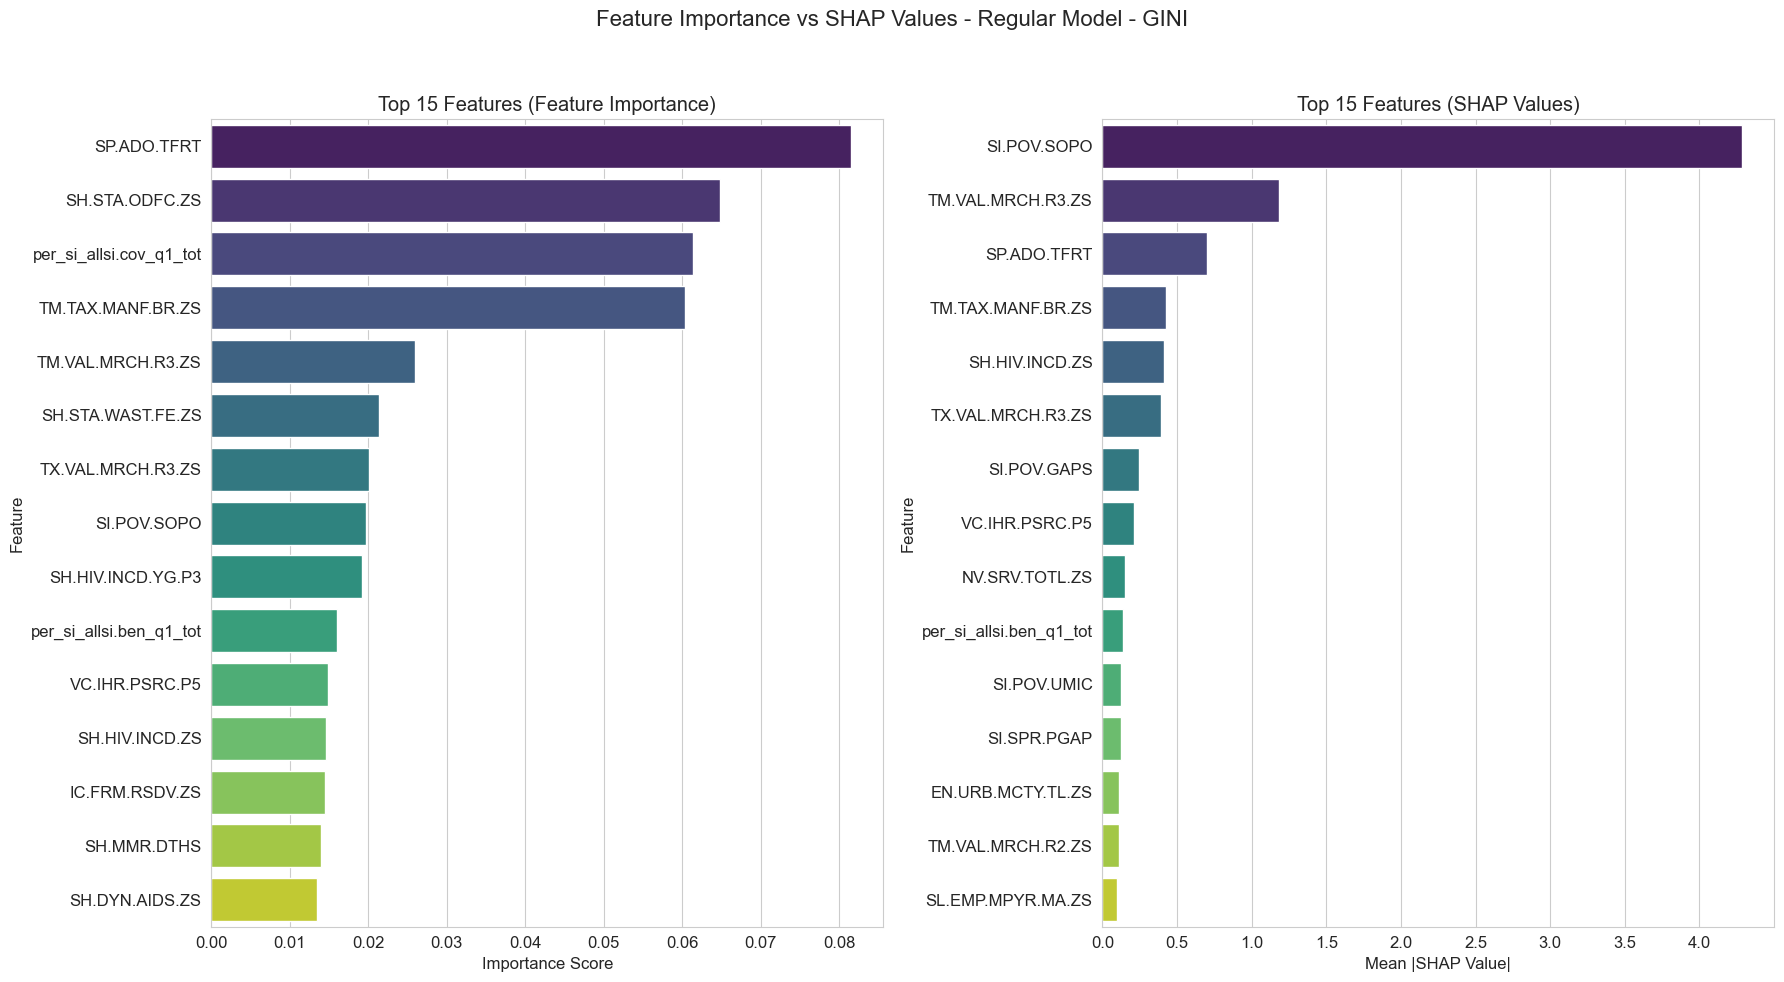

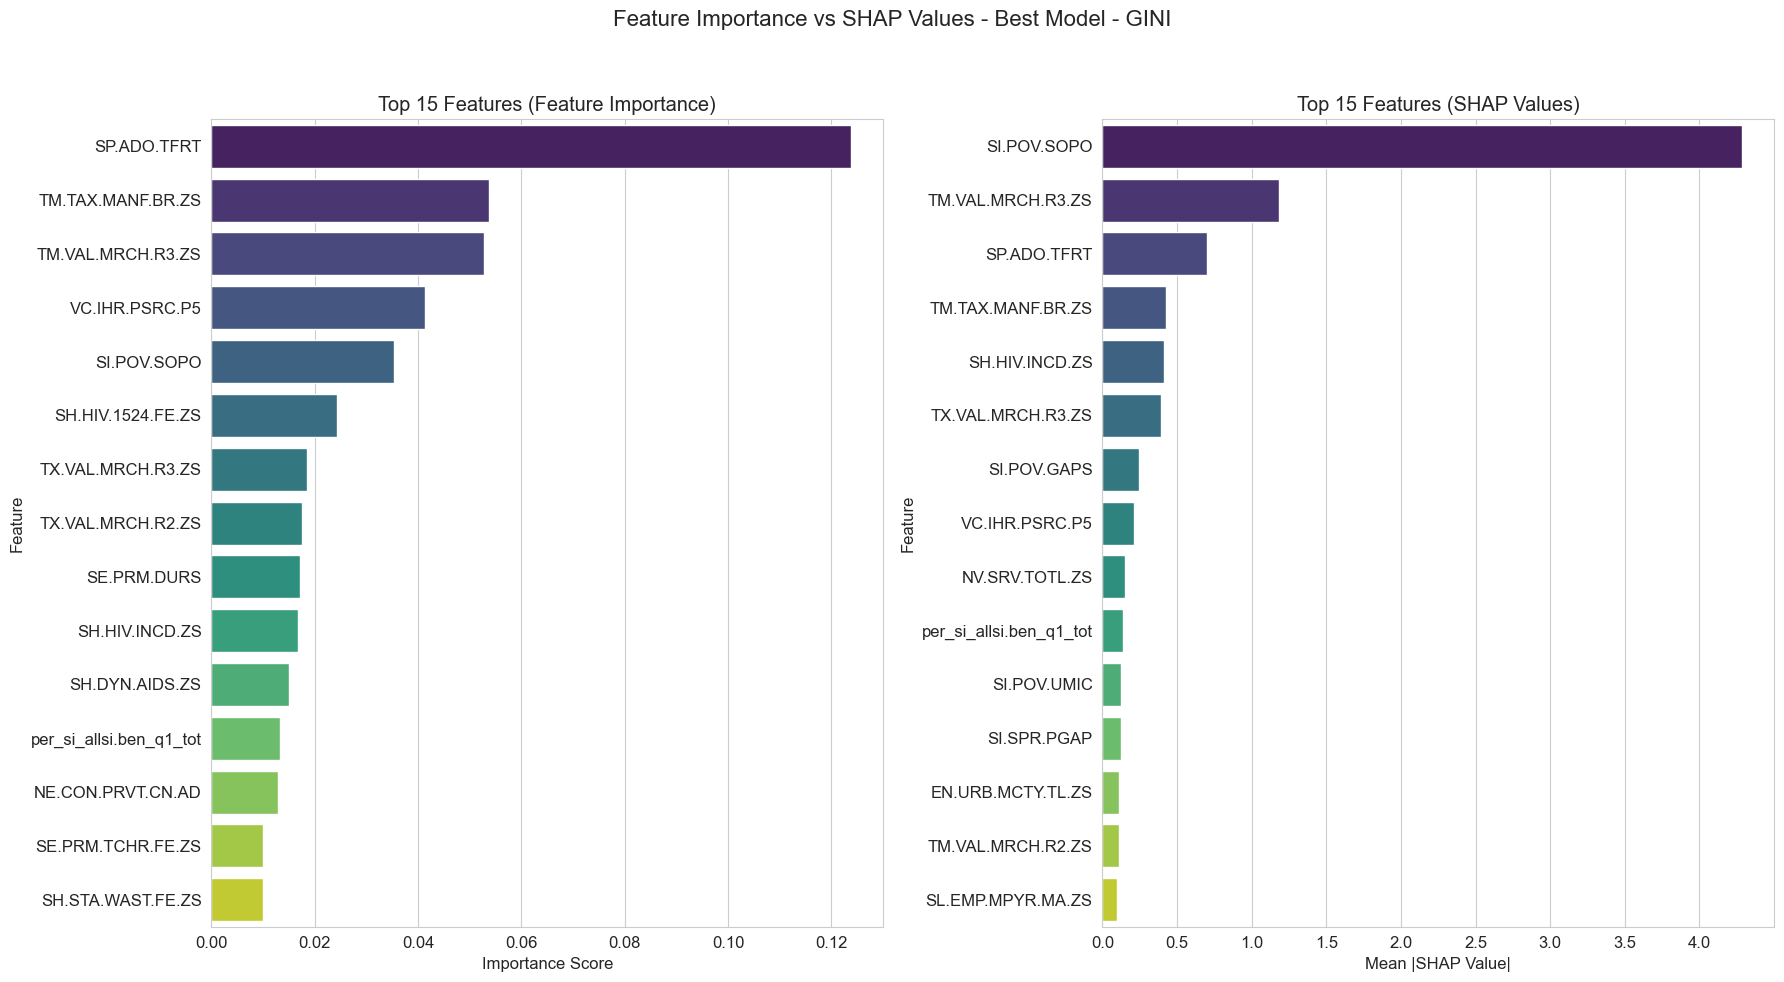

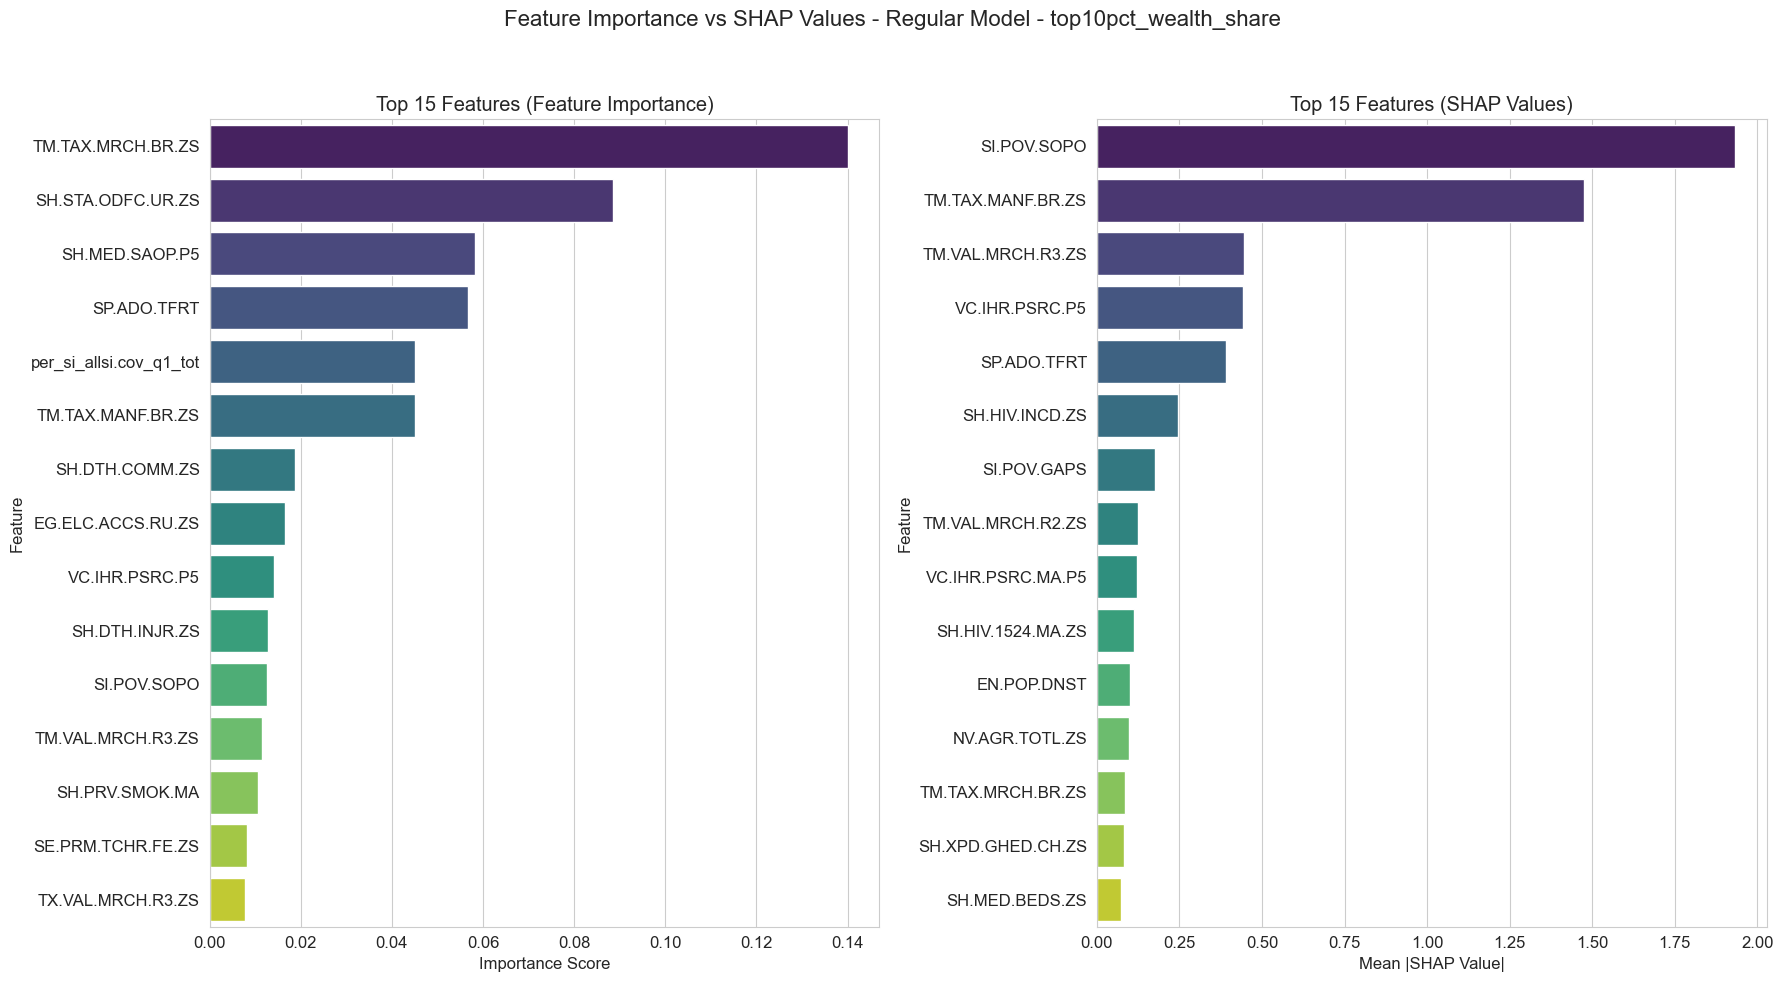

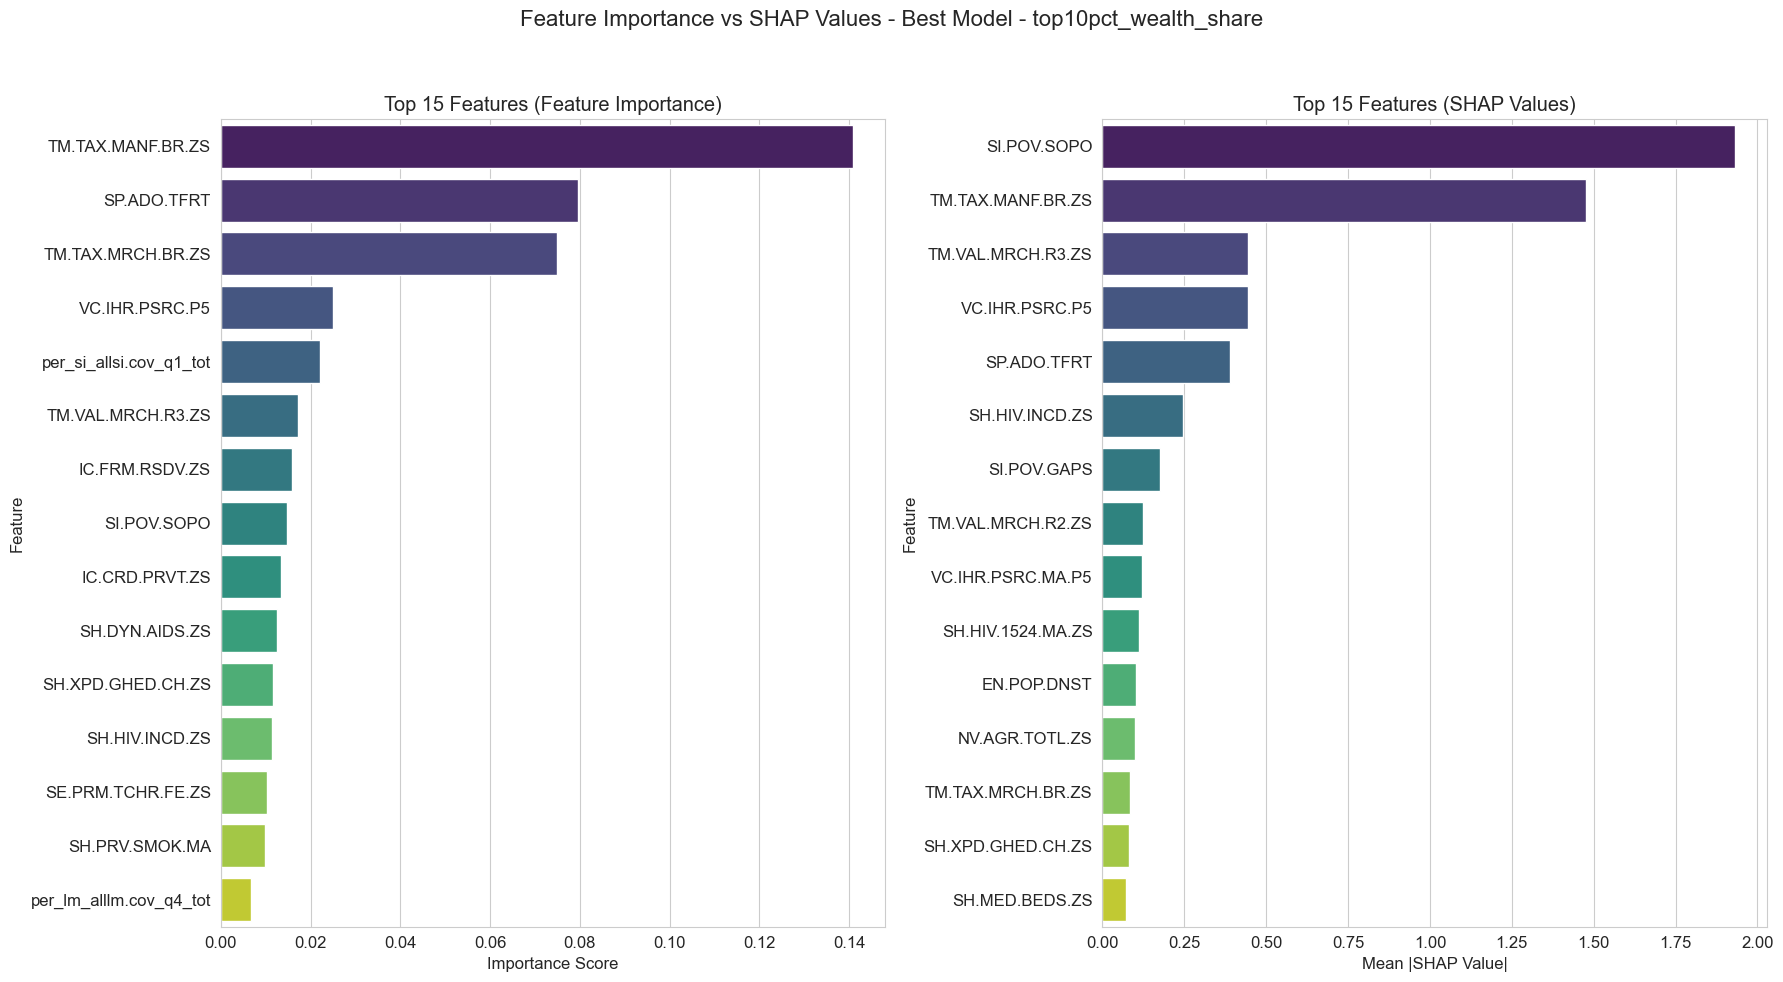

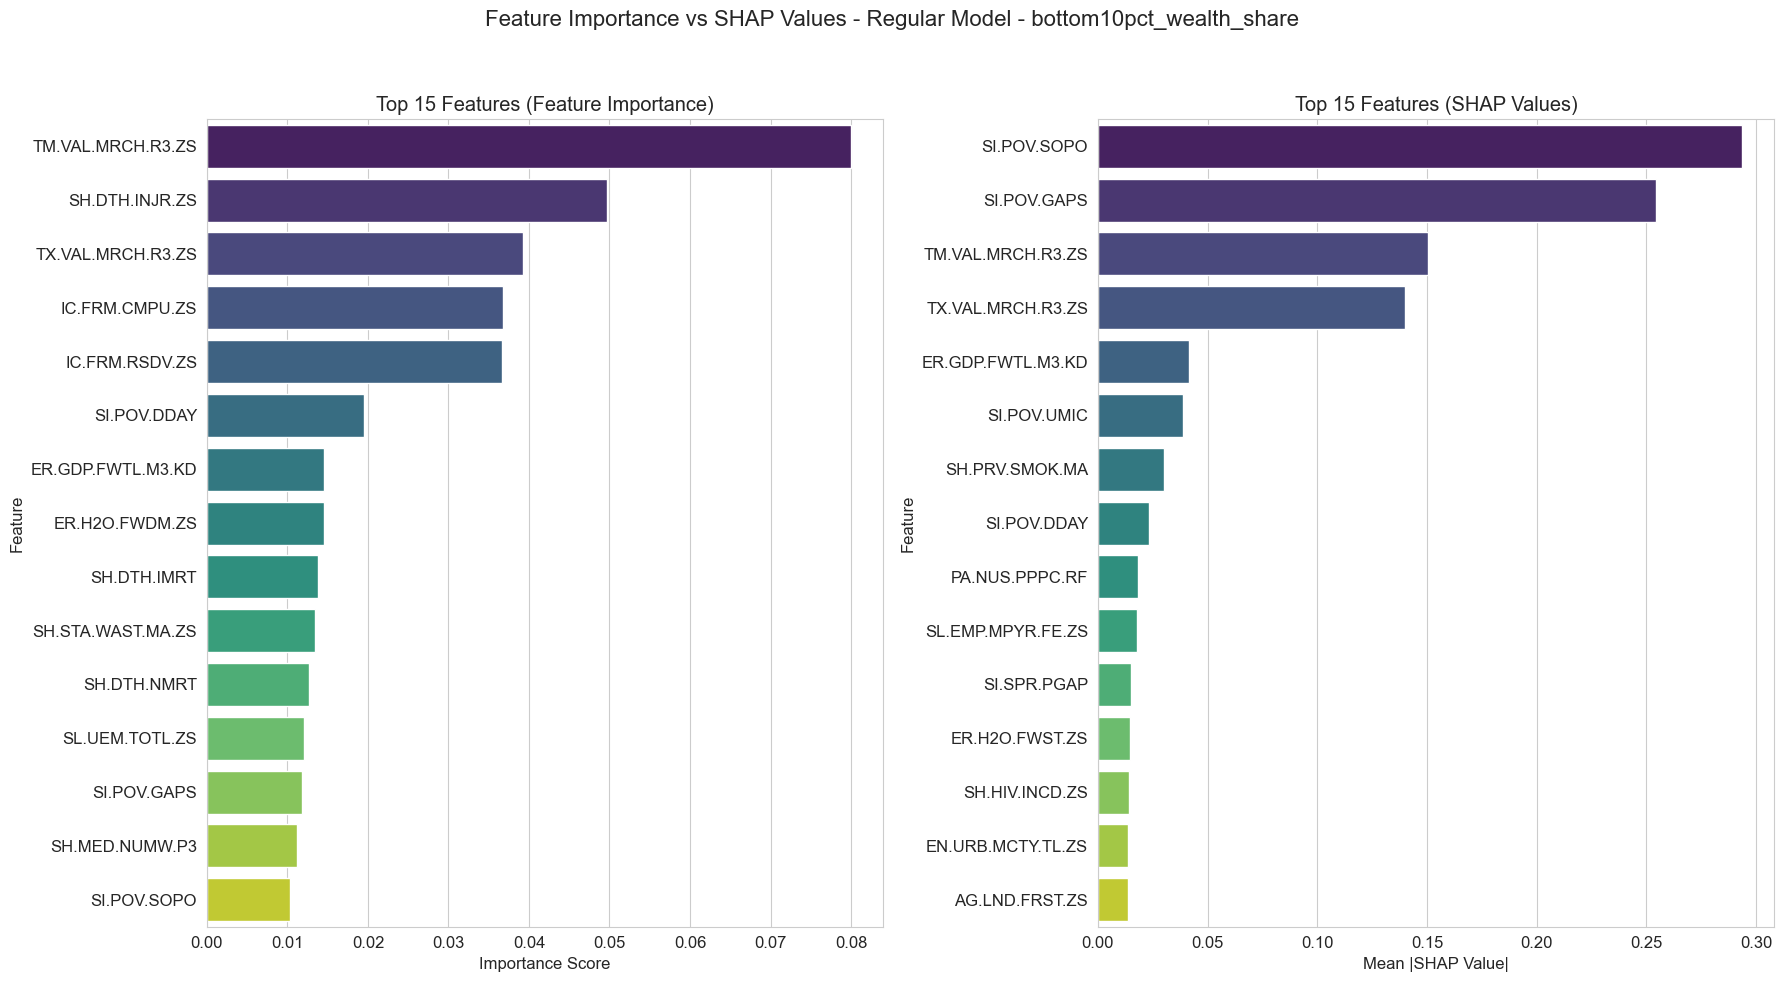

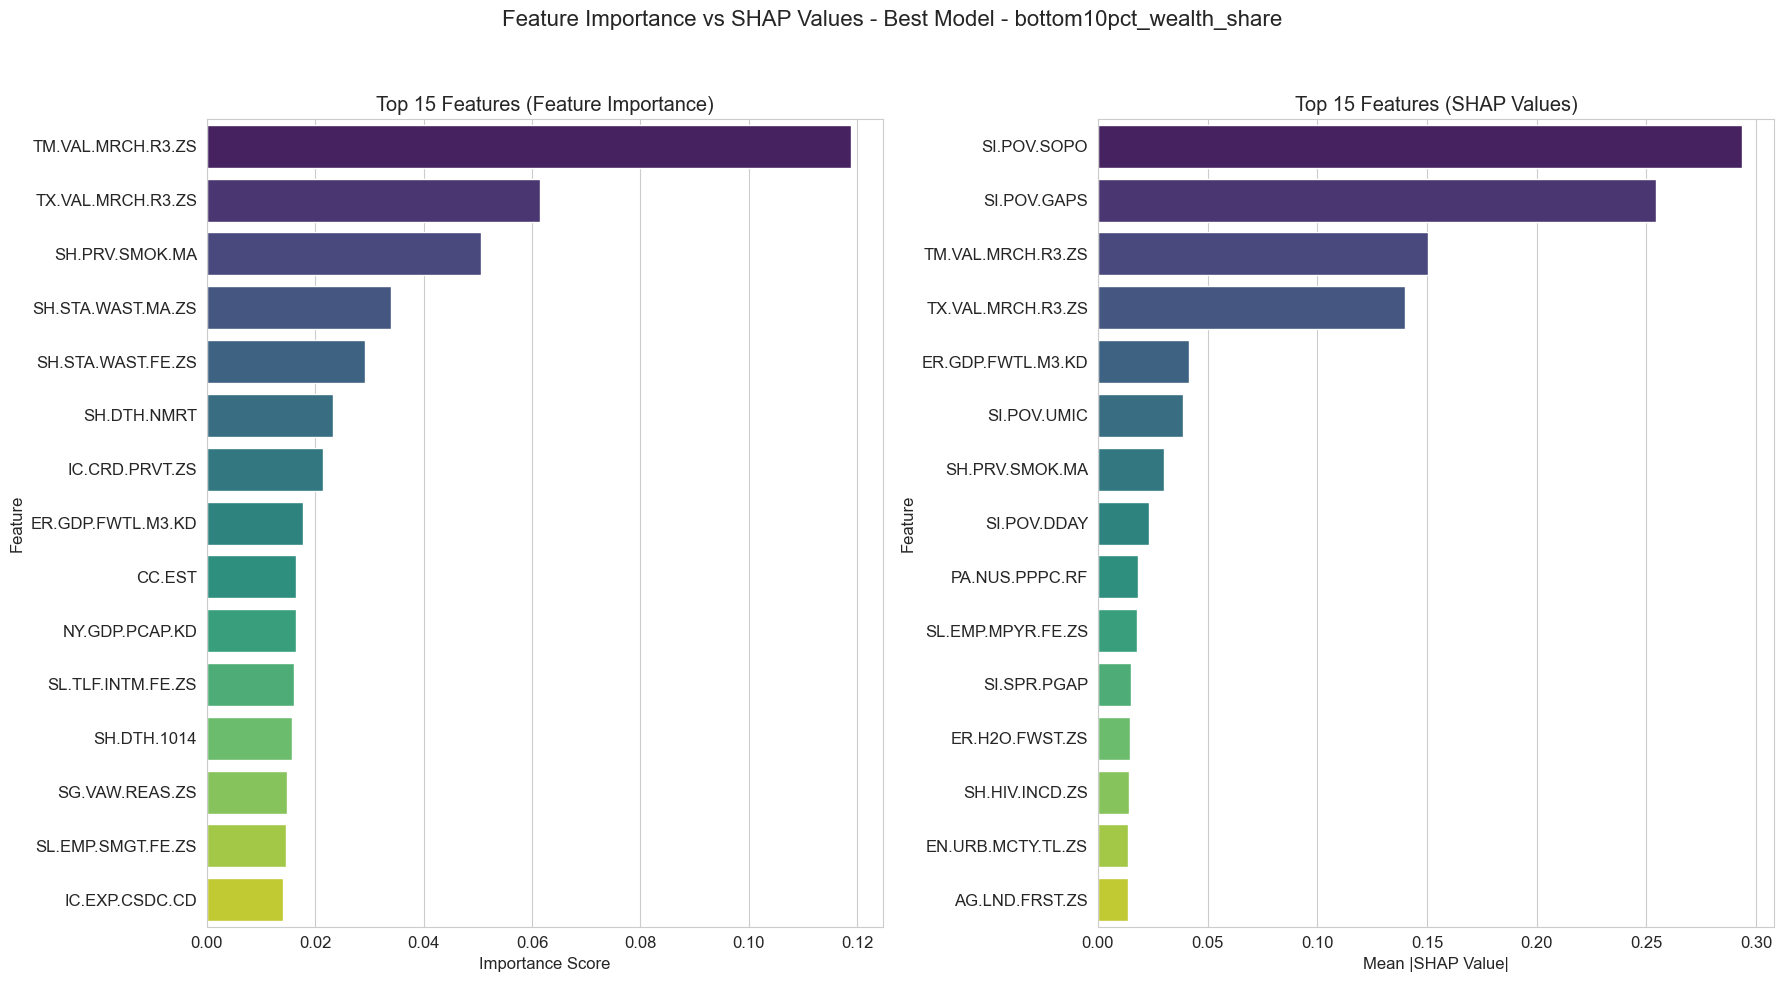

In [21]:
# Compare feature importance and SHAP values for each metric and model
for metric in metrics:
    # Regular model
    compare_feature_importance_and_shap(
        feature_importances[metric],
        shap_values[metric],
        f'Feature Importance vs SHAP Values - Regular Model - {metric}'
    )
    plt.show()
    
    # Best model
    compare_feature_importance_and_shap(
        best_feature_importances[metric],
        shap_values[metric],  # Note: we're using the same SHAP values for both models
        f'Feature Importance vs SHAP Values - Best Model - {metric}'
    )
    plt.show()

In [22]:
# Let's analyze the agreement between feature importance and SHAP values
def analyze_feature_ranking_agreement(feature_imp_df, shap_df, top_n=20):
    # Get top N features from each method
    top_fi_features = feature_imp_df.sort_values('Importance', ascending=False).head(top_n)['Feature'].tolist()
    top_shap_features = shap_df.sort_values('SHAP_Value', ascending=False).head(top_n)['Feature'].tolist()
    
    # Find common features
    common_features = set(top_fi_features).intersection(set(top_shap_features))
    
    # Calculate statistics
    agreement_pct = len(common_features) / top_n * 100
    
    # Create a table of features and their rankings
    combined_rankings = []
    
    # Combine all unique features from both top lists
    all_top_features = list(set(top_fi_features + top_shap_features))
    
    for feature in all_top_features:
        fi_rank = top_fi_features.index(feature) + 1 if feature in top_fi_features else None
        shap_rank = top_shap_features.index(feature) + 1 if feature in top_shap_features else None
        
        # Only include features that appear in at least one top list
        if fi_rank is not None or shap_rank is not None:
            combined_rankings.append({
                'Feature': feature,
                'FI Rank': fi_rank,
                'SHAP Rank': shap_rank,
                'In Both': 'Yes' if feature in common_features else 'No'
            })
    
    # Create DataFrame and sort by lowest rank (highest importance) in either method
    rankings_df = pd.DataFrame(combined_rankings)
    rankings_df['Min Rank'] = rankings_df[['FI Rank', 'SHAP Rank']].min(axis=1)
    rankings_df = rankings_df.sort_values('Min Rank').drop('Min Rank', axis=1)
    
    return {
        'common_features': common_features,
        'agreement_pct': agreement_pct,
        'rankings_df': rankings_df
    }

In [23]:
# Analyze agreement for each metric
for metric in metrics:
    print(f"\n=== Feature Ranking Agreement for {metric} ===\n")
    
    # Regular model analysis
    regular_agreement = analyze_feature_ranking_agreement(
        feature_importances[metric],
        shap_values[metric]
    )
    
    print(f"Regular Model Agreement: {regular_agreement['agreement_pct']:.2f}% of top 20 features appear in both lists")
    print("Top features and their rankings:")
    display(regular_agreement['rankings_df'].head(10))
    
    # Best model analysis
    best_agreement = analyze_feature_ranking_agreement(
        best_feature_importances[metric],
        shap_values[metric]
    )
    
    print(f"\nBest Model Agreement: {best_agreement['agreement_pct']:.2f}% of top 20 features appear in both lists")
    print("Top features and their rankings:")
    display(best_agreement['rankings_df'].head(10))
    
    print("\n" + "-"*50)


=== Feature Ranking Agreement for GINI ===

Regular Model Agreement: 40.00% of top 20 features appear in both lists
Top features and their rankings:


Feature  FI Rank  SHAP Rank In Both
26              SI.POV.SOPO      8.0        1.0     Yes
4               SP.ADO.TFRT      1.0        3.0     Yes
31           SH.STA.ODFC.ZS      2.0        NaN      No
18        TM.VAL.MRCH.R3.ZS      5.0        2.0     Yes
6   per_si_allsi.cov_q1_tot      3.0        NaN      No
20        TM.TAX.MANF.BR.ZS      4.0        4.0     Yes
25           SH.HIV.INCD.ZS     12.0        5.0     Yes
30        TX.VAL.MRCH.R3.ZS      7.0        6.0     Yes
14        SH.STA.WAST.FE.ZS      6.0        NaN      No
24              SI.POV.GAPS      NaN        7.0      No


Best Model Agreement: 45.00% of top 20 features appear in both lists
Top features and their rankings:


Feature  FI Rank  SHAP Rank In Both
26        SI.POV.SOPO      5.0        1.0     Yes
3         SP.ADO.TFRT      1.0        3.0     Yes
19  TM.TAX.MANF.BR.ZS      2.0        4.0     Yes
17  TM.VAL.MRCH.R3.ZS      3.0        2.0     Yes
18     VC.IHR.PSRC.P5      4.0        8.0     Yes
25     SH.HIV.INCD.ZS     10.0        5.0     Yes
30  TX.VAL.MRCH.R3.ZS      7.0        6.0     Yes
9   SH.HIV.1524.FE.ZS      6.0        NaN      No
24        SI.POV.GAPS      NaN        7.0      No
20  TX.VAL.MRCH.R2.ZS      8.0        NaN      No


--------------------------------------------------

=== Feature Ranking Agreement for top10pct_wealth_share ===

Regular Model Agreement: 30.00% of top 20 features appear in both lists
Top features and their rankings:


Feature  FI Rank  SHAP Rank In Both
29              SI.POV.SOPO     11.0        1.0     Yes
12        TM.TAX.MRCH.BR.ZS      1.0       13.0     Yes
4         SH.STA.ODFC.UR.ZS      2.0        NaN      No
21        TM.TAX.MANF.BR.ZS      6.0        2.0     Yes
13           SH.MED.SAOP.P5      3.0        NaN      No
19        TM.VAL.MRCH.R3.ZS     12.0        3.0     Yes
20           VC.IHR.PSRC.P5      9.0        4.0     Yes
3               SP.ADO.TFRT      4.0        5.0     Yes
7   per_si_allsi.cov_q1_tot      5.0        NaN      No
27           SH.HIV.INCD.ZS      NaN        6.0      No


Best Model Agreement: 45.00% of top 20 features appear in both lists
Top features and their rankings:


Feature  FI Rank  SHAP Rank In Both
29              SI.POV.SOPO      8.0        1.0     Yes
20        TM.TAX.MANF.BR.ZS      1.0        2.0     Yes
4               SP.ADO.TFRT      2.0        5.0     Yes
18        TM.VAL.MRCH.R3.ZS      6.0        3.0     Yes
11        TM.TAX.MRCH.BR.ZS      3.0       13.0     Yes
19           VC.IHR.PSRC.P5      4.0        4.0     Yes
6   per_si_allsi.cov_q1_tot      5.0        NaN      No
27           SH.HIV.INCD.ZS     12.0        6.0     Yes
22           IC.FRM.RSDV.ZS      7.0        NaN      No
26              SI.POV.GAPS      NaN        7.0      No


--------------------------------------------------

=== Feature Ranking Agreement for bottom10pct_wealth_share ===

Regular Model Agreement: 35.00% of top 20 features appear in both lists
Top features and their rankings:


Feature  FI Rank  SHAP Rank In Both
25        SI.POV.SOPO     15.0        1.0     Yes
15  TM.VAL.MRCH.R3.ZS      1.0        3.0     Yes
22        SI.POV.GAPS     13.0        2.0     Yes
4      SH.DTH.INJR.ZS      2.0        NaN      No
30  TX.VAL.MRCH.R3.ZS      3.0        4.0     Yes
31     IC.FRM.CMPU.ZS      4.0        NaN      No
6   ER.GDP.FWTL.M3.KD      7.0        5.0     Yes
17     IC.FRM.RSDV.ZS      5.0        NaN      No
11        SI.POV.UMIC      NaN        6.0      No
18        SI.POV.DDAY      6.0        8.0     Yes


Best Model Agreement: 35.00% of top 20 features appear in both lists
Top features and their rankings:


Feature  FI Rank  SHAP Rank In Both
28        SI.POV.SOPO     17.0        1.0     Yes
19  TM.VAL.MRCH.R3.ZS      1.0        3.0     Yes
32  TX.VAL.MRCH.R3.ZS      2.0        4.0     Yes
25        SI.POV.GAPS     18.0        2.0     Yes
7      SH.PRV.SMOK.MA      3.0        7.0     Yes
2   SH.STA.WAST.MA.ZS      4.0       17.0     Yes
17  SH.STA.WAST.FE.ZS      5.0        NaN      No
10  ER.GDP.FWTL.M3.KD      8.0        5.0     Yes
20        SH.DTH.NMRT      6.0        NaN      No
16        SI.POV.UMIC      NaN        6.0      No


--------------------------------------------------


In [24]:
# Analyze the correlation between feature importance and SHAP values
def feature_importance_shap_correlation(feature_imp_df, shap_df):
    # Merge the two dataframes on Feature column
    merged_df = pd.merge(feature_imp_df, shap_df, on='Feature', how='inner')
    
    # Calculate correlation
    correlation = merged_df['Importance'].corr(merged_df['SHAP_Value'])
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['Importance'], merged_df['SHAP_Value'], alpha=0.5)
    plt.title(f'Correlation between Feature Importance and SHAP Values (r = {correlation:.4f})')
    plt.xlabel('Feature Importance')
    plt.ylabel('Mean |SHAP Value|')
    plt.grid(True)
    
    # Add a regression line
    z = np.polyfit(merged_df['Importance'], merged_df['SHAP_Value'], 1)
    p = np.poly1d(z)
    plt.plot(merged_df['Importance'], p(merged_df['Importance']), 'r--')
    
    # Annotate with the correlation value
    plt.annotate(f'Correlation: {correlation:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    return plt.gcf(), correlation


=== Correlation Analysis for GINI ===



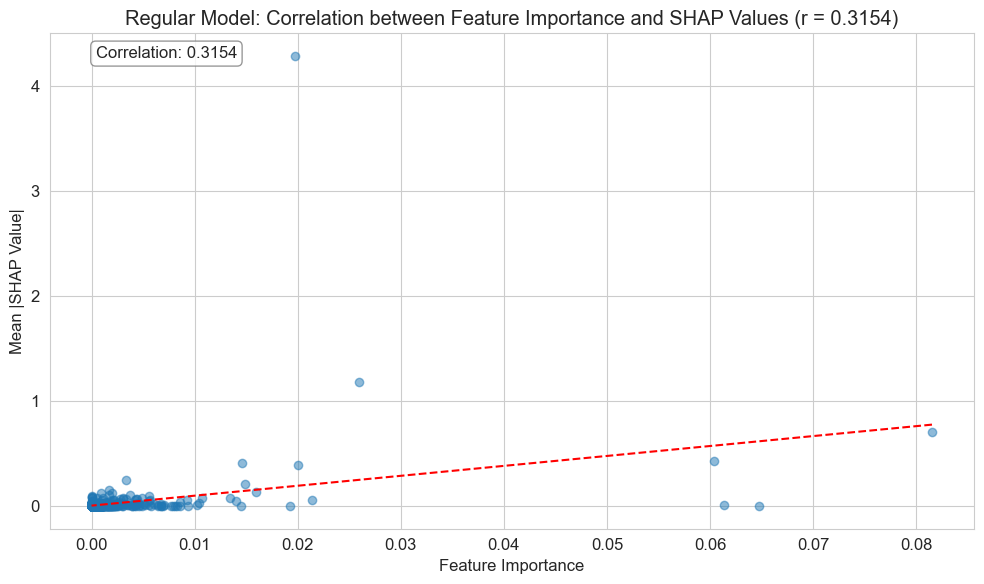

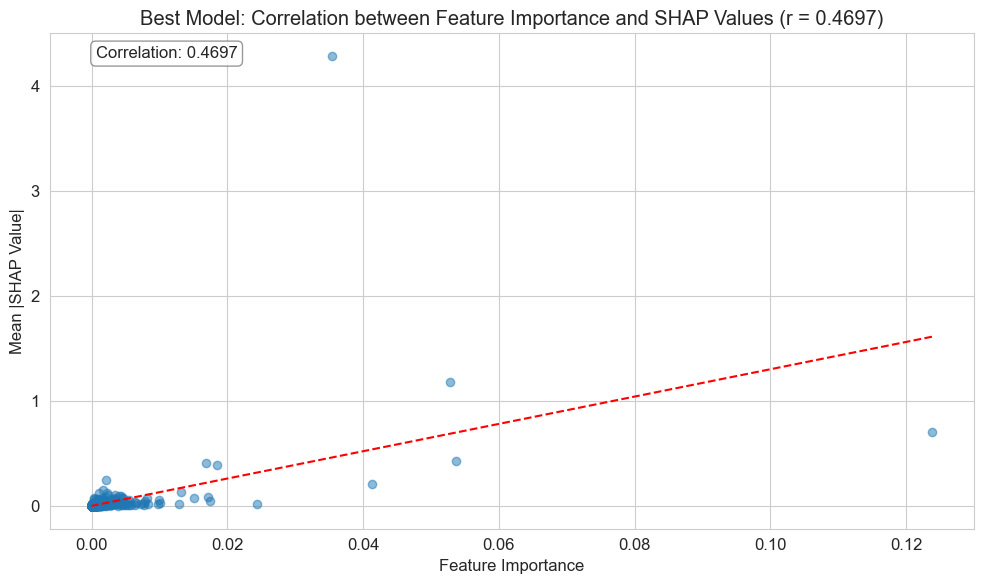


=== Correlation Analysis for top10pct_wealth_share ===



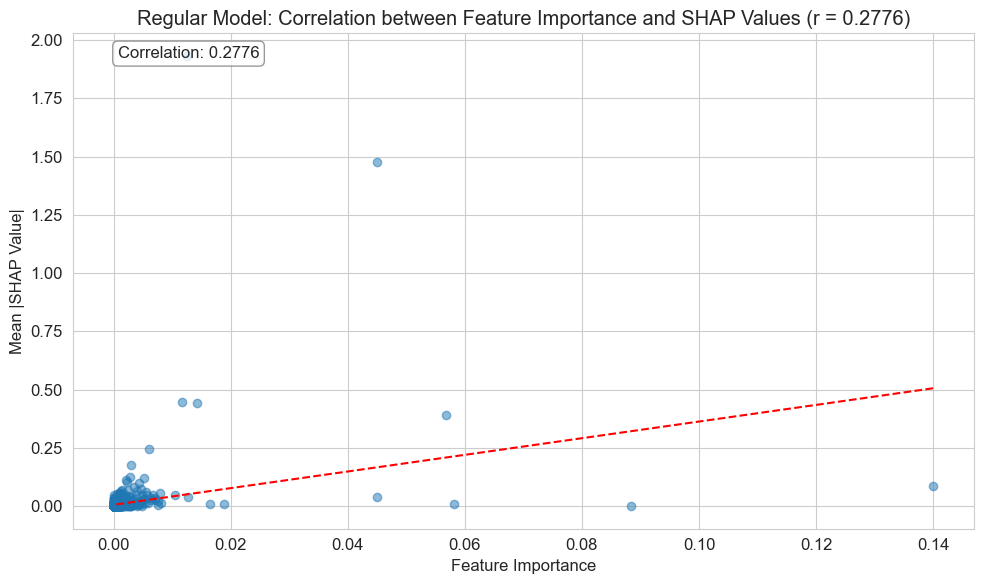

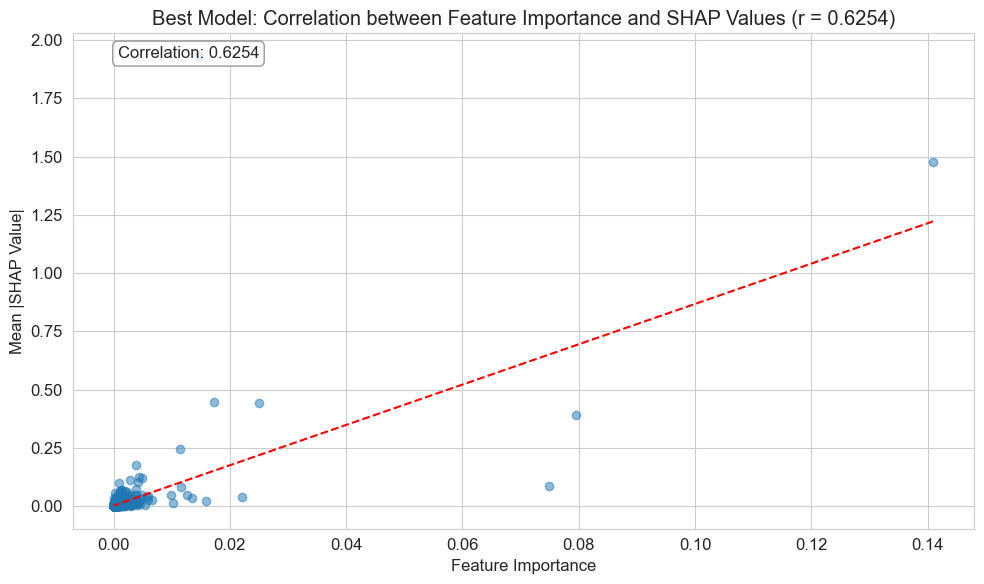


=== Correlation Analysis for bottom10pct_wealth_share ===



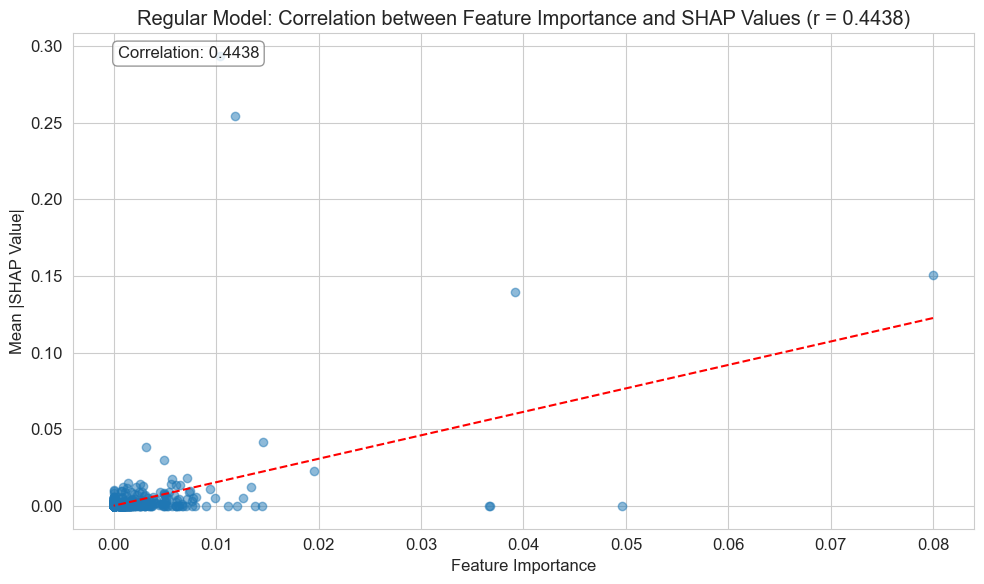

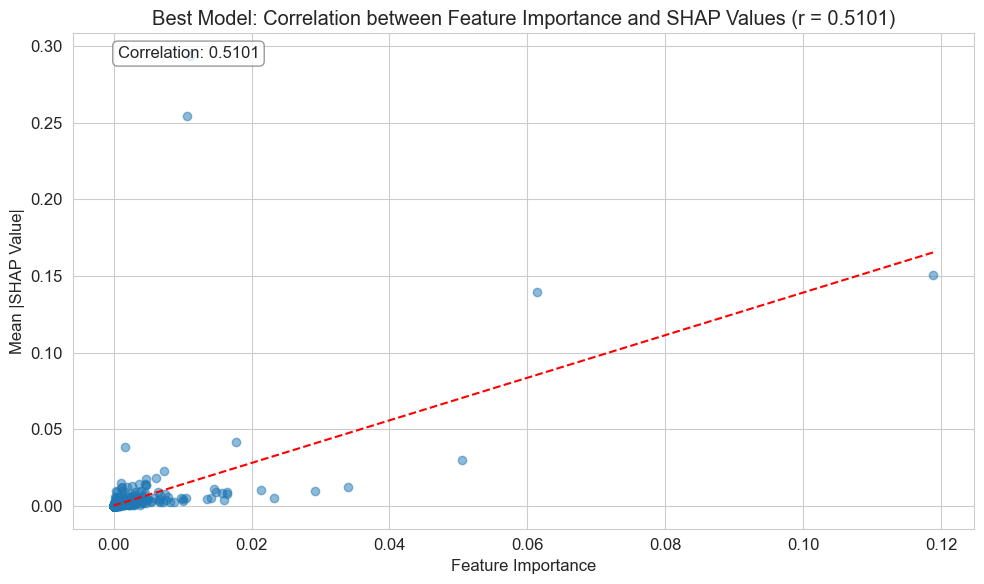

In [25]:
# Calculate correlation for each metric and model
for metric in metrics:
    print(f"\n=== Correlation Analysis for {metric} ===\n")
    
    # Regular model correlation
    fig, corr = feature_importance_shap_correlation(
        feature_importances[metric],
        shap_values[metric]
    )
    plt.title(f'Regular Model: Correlation between Feature Importance and SHAP Values (r = {corr:.4f})')
    plt.show()
    
    # Best model correlation
    fig, corr = feature_importance_shap_correlation(
        best_feature_importances[metric],
        shap_values[metric]
    )
    plt.title(f'Best Model: Correlation between Feature Importance and SHAP Values (r = {corr:.4f})')
    plt.show()

## Cross-Metric Feature Importance Analysis

Let's now compare which features are important across the different metrics to identify common drivers of inequality.

In [26]:
# Function to identify common important features across metrics
def compare_important_features_across_metrics(shap_values_dict, top_n=20):
    # Get top features for each metric
    top_features = {}
    for metric, df in shap_values_dict.items():
        top_features[metric] = df.sort_values('SHAP_Value', ascending=False).head(top_n)['Feature'].tolist()
    
    # Find features that appear in multiple metrics
    all_top_features = set()
    for features in top_features.values():
        all_top_features.update(features)
    
    # Create a matrix of feature presence across metrics
    feature_matrix = []
    for feature in all_top_features:
        feature_info = {'Feature': feature}
        
        # Add rank in each metric, or None if not in top
        for metric, features in top_features.items():
            feature_info[f'{metric} Rank'] = features.index(feature) + 1 if feature in features else None
            feature_info[f'{metric} SHAP'] = shap_values_dict[metric][shap_values_dict[metric]['Feature'] == feature]['SHAP_Value'].values[0] if feature in features else 0
        
        # Count in how many metrics the feature appears
        feature_info['Metrics Count'] = sum(1 for metric in metrics if feature_info[f'{metric} Rank'] is not None)
        
        feature_matrix.append(feature_info)
    
    # Convert to DataFrame and sort by presence in multiple metrics, then by average rank
    matrix_df = pd.DataFrame(feature_matrix)
    
    # Calculate average SHAP value across metrics (ignoring zeros)
    matrix_df['Avg SHAP'] = matrix_df[[f'{metric} SHAP' for metric in metrics]].replace(0, np.nan).mean(axis=1)
    
    # Sort by metrics count (descending) and then by average SHAP (descending)
    matrix_df = matrix_df.sort_values(['Metrics Count', 'Avg SHAP'], ascending=[False, False])
    
    return matrix_df

In [27]:
# Compare important features across all three inequality metrics
cross_metric_analysis = compare_important_features_across_metrics(shap_values)

# Display features that appear in multiple metrics
print("Features that appear as important across multiple inequality metrics:")
display(cross_metric_analysis[cross_metric_analysis['Metrics Count'] > 1].head(15))

# Display features that are uniquely important for each metric
for metric in metrics:
    unique_features = cross_metric_analysis[(cross_metric_analysis['Metrics Count'] == 1) & 
                                           (cross_metric_analysis[f'{metric} Rank'].notna())].head(5)
    print(f"\nTop 5 features uniquely important for {metric}:")
    display(unique_features[['Feature', f'{metric} Rank', f'{metric} SHAP']])

Features that appear as important across multiple inequality metrics:


Feature  GINI Rank  GINI SHAP  top10pct_wealth_share Rank  \
32        SI.POV.SOPO        1.0   4.284902                         1.0   
23  TM.VAL.MRCH.R3.ZS        2.0   1.184993                         3.0   
29        SI.POV.GAPS        7.0   0.245055                         7.0   
30     SH.HIV.INCD.ZS        5.0   0.411826                         6.0   
1         SI.SPR.PGAP       12.0   0.126161                        16.0   
28  EN.URB.MCTY.TL.ZS       13.0   0.109851                        17.0   
25  TM.TAX.MANF.BR.ZS        4.0   0.427895                         2.0   
5         SP.ADO.TFRT        3.0   0.703954                         5.0   
24     VC.IHR.PSRC.P5        8.0   0.214218                         4.0   
37  TX.VAL.MRCH.R3.ZS        6.0   0.391270                         NaN   
21  TM.VAL.MRCH.R2.ZS       14.0   0.108591                         8.0   
18        SI.POV.UMIC       11.0   0.127022                         NaN   
34  SL.EMP.MPYR.MA.ZS       15.0   0.096273                        20.0   
31        EN.POP.DNST        NaN   0.000000                        11.0   
35     PA.NUS.PPPC.RF       17.0   0.082882                         NaN   

    top10pct_wealth_share SHAP  bottom10pct_wealth_share Rank  \
32                    1.931886                            1.0   
23                    0.446000                            3.0   
29                    0.174662                            2.0   
30                    0.246322                           13.0   
1                     0.070851                           11.0   
28                    0.068138                           14.0   
25                    1.476584                            NaN   
5                     0.389903                            NaN   
24                    0.443217                            NaN   
37                    0.000000                            4.0   
21                    0.123982                            NaN   
18                    0.000000                            6.0   
34                    0.062508                            NaN   
31                    0.101733                           16.0   
35                    0.000000                            9.0   

    bottom10pct_wealth_share SHAP  Metrics Count  Avg SHAP  
32                       0.293559              3  2.170116  
23                       0.150717              3  0.593903  
29                       0.254292              3  0.224670  
30                       0.014203              3  0.224117  
1                        0.014956              3  0.070656  
28                       0.013590              3  0.063860  
25                       0.000000              2  0.952239  
5                        0.000000              2  0.546929  
24                       0.000000              2  0.328718  
37                       0.139919              2  0.265594  
21                       0.000000              2  0.116287  
18                       0.038831              2  0.082927  
34                       0.000000              2  0.079390  
31                       0.012978              2  0.057355  
35                       0.018313              2  0.050597


Top 5 features uniquely important for GINI:


Feature  GINI Rank  GINI SHAP
0            NV.SRV.TOTL.ZS        9.0   0.153291
17  per_si_allsi.ben_q1_tot       10.0   0.135280
33        SL.AGR.EMPL.FE.ZS       16.0   0.096059
11              SE.PRM.DURS       18.0   0.082627
7            SM.POP.TOTL.ZS       19.0   0.081859


Top 5 features uniquely important for top10pct_wealth_share:


Feature  top10pct_wealth_share Rank  top10pct_wealth_share SHAP
8   VC.IHR.PSRC.MA.P5                         9.0                    0.121222
6   SH.HIV.1524.MA.ZS                        10.0                    0.111891
16     NV.AGR.TOTL.ZS                        12.0                    0.098857
13  TM.TAX.MRCH.BR.ZS                        13.0                    0.085264
19  SH.XPD.GHED.CH.ZS                        14.0                    0.081800


Top 5 features uniquely important for bottom10pct_wealth_share:


Feature  bottom10pct_wealth_share Rank  \
12  ER.GDP.FWTL.M3.KD                            5.0   
9      SH.PRV.SMOK.MA                            7.0   
26        SI.POV.DDAY                            8.0   
15  SL.EMP.MPYR.FE.ZS                           10.0   
27     AG.LND.FRST.ZS                           15.0   

    bottom10pct_wealth_share SHAP  
12                       0.041755  
9                        0.030055  
26                       0.023204  
15                       0.017868  
27                       0.013507

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45388 sha256=08caebb124143a22b2d4a18f7403fe2114f32c02e02a8aa5033da95eee679cb5
  Stored in directory: /Users/garrettflowers/Library/Caches/pip/wheels/c4/16/4a/93374cd955bbe0553a8ce74db7f0fbd5fcc876e19fb78bd601
Successfully built matplotlib-venn
Note: you may need to restart the kernel to use updated packages.


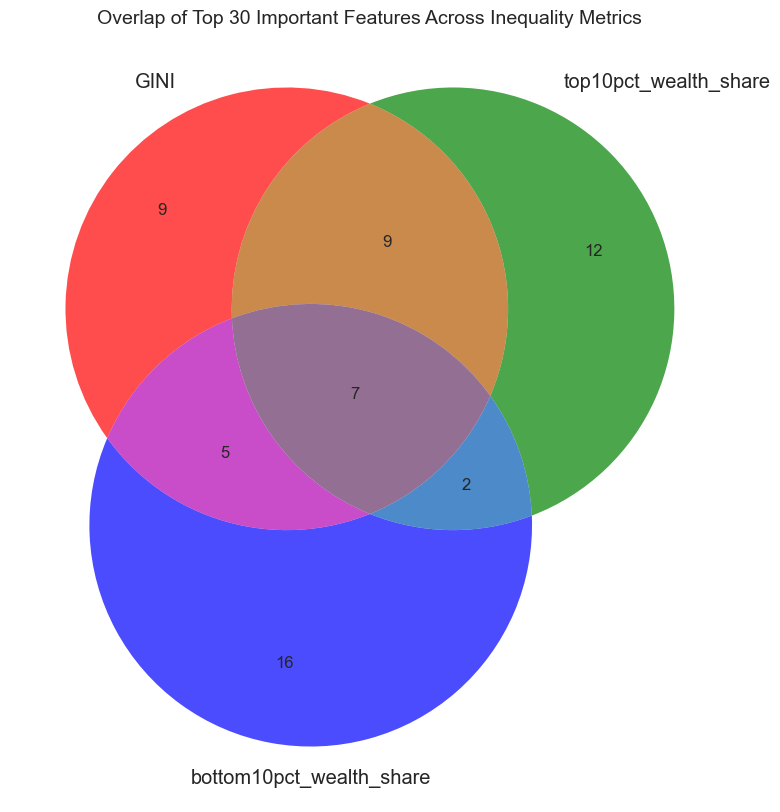

Features important for all three metrics: 7
Common features: SI.SPR.PGAP, SI.POV.GAPS, SH.HIV.INCD.ZS, TM.VAL.MRCH.R3.ZS, SI.POV.SOPO, TX.VAL.MRCH.R3.ZS, EN.URB.MCTY.TL.ZS


In [ ]:
# Visualize the overlap of important features between metrics using a Venn diagram
from matplotlib_venn import venn3

# Get sets of top features for each metric
top_features_sets = {metric: set(shap_values[metric].sort_values('SHAP_Value', 
                                                              ascending=False).head(30)['Feature']) 
                  for metric in metrics}

# Create Venn diagram
plt.figure(figsize=(10, 10))
venn3([top_features_sets[m] for m in metrics], 
     set_labels=metrics,
     alpha=0.7)

plt.title('Overlap of Top 30 Important Features Across Inequality Metrics', fontsize=14)
plt.show()

# Calculate and display the number of overlapping features
all_metrics = set.intersection(*top_features_sets.values())
print(f"Features important for all three metrics: {len(all_metrics)}")
if len(all_metrics) > 0:
    print(f"Common features: {', '.join(all_metrics)}")